In [1]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

In [2]:
ScaleTo = 70  # px to scale
seed = 7  # fixing random

path = 'train/*/*.png' 
files = glob(path)

In [5]:
files

['train\\Black-grass\\0050f38b3.png',
 'train\\Black-grass\\0183fdf68.png',
 'train\\Black-grass\\0260cffa8.png',
 'train\\Black-grass\\05eedce4d.png',
 'train\\Black-grass\\075d004bc.png',
 'train\\Black-grass\\078eae073.png',
 'train\\Black-grass\\082314602.png',
 'train\\Black-grass\\0ace21089.png',
 'train\\Black-grass\\0b228a6b8.png',
 'train\\Black-grass\\0b3e7a7a9.png',
 'train\\Black-grass\\0bb75ded8.png',
 'train\\Black-grass\\0be707615.png',
 'train\\Black-grass\\0c67c3fc3.png',
 'train\\Black-grass\\0d1a9985f.png',
 'train\\Black-grass\\0d28c429b.png',
 'train\\Black-grass\\0d4f74f4a.png',
 'train\\Black-grass\\0dad57e7f.png',
 'train\\Black-grass\\0e91f92a1.png',
 'train\\Black-grass\\0fe440ed5.png',
 'train\\Black-grass\\1276dffba.png',
 'train\\Black-grass\\129c51855.png',
 'train\\Black-grass\\13a7f553a.png',
 'train\\Black-grass\\14719a83e.png',
 'train\\Black-grass\\1576ce9fd.png',
 'train\\Black-grass\\163c13912.png',
 'train\\Black-grass\\163e571a6.png',
 'train\\Bla

In [3]:
trainImg = []
trainLabel = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('\\')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

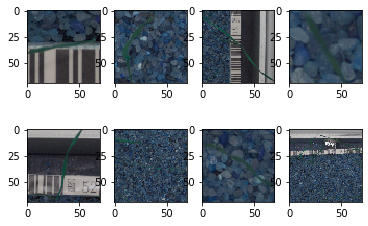

In [7]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

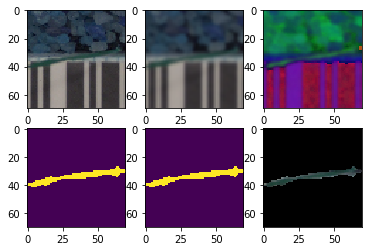

In [8]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

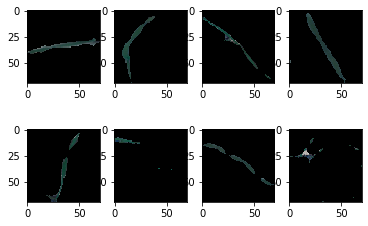

In [9]:
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

In [10]:
clearTrainImg = clearTrainImg / 255

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


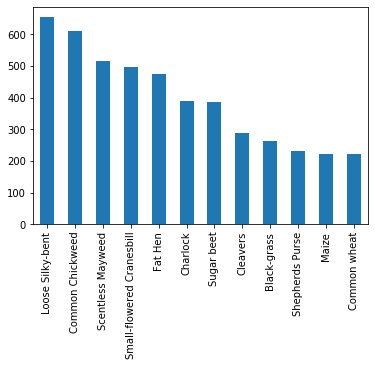

In [11]:
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

In [12]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, random_state=seed, 
                                                stratify = clearTrainLabel)

In [13]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

In [14]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization

numpy.random.seed(seed)  # Fix seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
________________________________________________

In [35]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="reco/weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
filepath="reco/weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

# fit model
hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=75), epochs=35, validation_data=(testX, testY), callbacks=callbacks_list)

Epoch 1/35
57/57 [==============================] - 565s 10s/step - loss: 0.7339 - accuracy: 0.7542 - val_loss: 0.5648 - val_accuracy: 0.7916

Epoch 00001: val_accuracy improved from -inf to 0.79158, saving model to reco/weights.best_01-0.79.hdf5

Epoch 00001: saving model to reco/weights.last_auto4.hdf5
Epoch 2/35
57/57 [==============================] - 566s 10s/step - loss: 0.7022 - accuracy: 0.7694 - val_loss: 0.7060 - val_accuracy: 0.7600

Epoch 00002: val_accuracy did not improve from 0.79158

Epoch 00002: saving model to reco/weights.last_auto4.hdf5
Epoch 3/35
57/57 [==============================] - 563s 10s/step - loss: 0.6730 - accuracy: 0.7757 - val_loss: 0.5920 - val_accuracy: 0.8021

Epoch 00003: val_accuracy improved from 0.79158 to 0.80211, saving model to reco/weights.best_03-0.80.hdf5

Epoch 00003: saving model to reco/weights.last_auto4.hdf5
Epoch 4/35
57/57 [==============================] - 570s 10s/step - loss: 0.6602 - accuracy: 0.7771 - val_loss: 0.5700 - val_acc

In [36]:
model.load_weights("reco/weights.best_20-0.88.hdf5")

In [37]:
print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.evaluate(testX, testY))  # Evaluate on test set

4275/4275 [==============================] - 128s 30ms/step
[0.32586333346645735, 0.8814035058021545]
475/475 [==============================] - 15s 32ms/step
[0.3342186280300743, 0.88210529088974]


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

In [23]:
path = 'test/*.png'
files = glob(path)

In [25]:
'test\\148bbda66.png'.split('\\')

['test', '148bbda66.png']

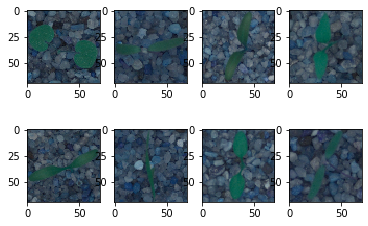

In [26]:
path = 'test/*.png'
files = glob(path)

testImg = []
testId = []
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print("Obtain images: " + str(j) + "/" + str(num), end='\r')
    testId.append(img.split('\\')[-1])  # Images id's
    testImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))
    j += 1

testImg = np.asarray(testImg)  # Train images set

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(testImg[i])

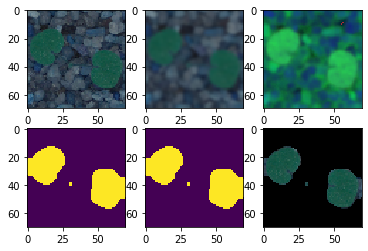

In [27]:
clearTestImg = []
examples = []; getEx = True
for img in testImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTestImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTestImg = np.asarray(clearTestImg)

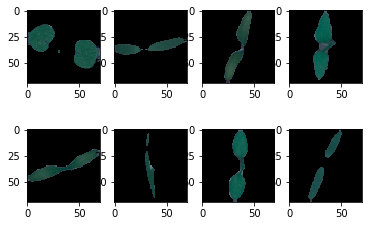

In [28]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTestImg[i])

In [29]:
clearTestImg = clearTestImg / 255

In [38]:
pred = model.predict(clearTestImg)

In [40]:
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)


In [41]:
res.to_csv("result/result_v2.csv", index=False)

# tranfer learning

In [50]:

import numpy as np 
import pandas as pd 
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import cv2
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from keras.utils import np_utils
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [69]:
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (70, 70, 3))
for layer in model.layers[:5]:
    layer.trainable = False

x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation="softmax")(x) 

model_final = Model(input = model.input, output = predictions)

model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
model_final.summary()

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  del sys.path[0]


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 70, 70, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 70, 70, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 70, 70, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 35, 35, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 35, 35, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 35, 35, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 17, 17, 128)       0   

In [52]:
gen = ImageDataGenerator(
            rotation_range=360.,
            width_shift_range=0.3,
            height_shift_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            vertical_flip=True)

In [56]:
train_data_dir = "C:/Users/USER/plant-seedlings-classification/train/"
train_generator = gen.flow_from_directory(
                        train_data_dir,
                        target_size = (240, 240),
                        batch_size = 16, 
                        class_mode = "categorical")

Found 4750 images belonging to 12 classes.


In [61]:
train_generator.n

4750

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
train, val = train_test_split( train_generator, test_size=0.3, random_state=42)

In [70]:
checkpoint = ModelCheckpoint("reco/vgg16_withvalid.h5", monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [71]:
batchsize = 16
STEP_SIZE_TRAIN=len(trainX)/batchsize
STEP_SIZE_VALID=len(testX)/batchsize
trainX, testX, trainY, testY
model_final.fit_generator(
                    datagen.flow(trainX, trainY, batch_size=16),
                    validation_data=(testX,testY),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID,
                    epochs = 50,
                    shuffle= True,
                    callbacks = [checkpoint, early])

(array([[[[0.09803922, 0.16470588, 0.25098039],
          [0.16078431, 0.25098039, 0.3254902 ],
          [0.21960784, 0.29411765, 0.37254902],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.2       , 0.27843137, 0.34901961],
          [0.27843137, 0.32156863, 0.37254902],
          [0.32941176, 0.39215686, 0.45490196],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.20784314, 0.28235294, 0.36862745],
          [0.18431373, 0.2627451 , 0.34509804],
          [0.23137255, 0.3372549 , 0.41960784],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

Epoch 1/50


183/267 [===================>..........] - ETA: 18:35 - loss: 3.0684 - accuracy: 0.0000e+0 - ETA: 14:55 - loss: 2.9545 - accuracy: 0.0312    - ETA: 13:09 - loss: 2.8688 - accuracy: 0.041 - ETA: 12:31 - loss: 2.9657 - accuracy: 0.031 - ETA: 12:18 - loss: 2.9578 - accuracy: 0.037 - ETA: 12:07 - loss: 2.9182 - accuracy: 0.041 - ETA: 12:05 - loss: 2.9073 - accuracy: 0.035 - ETA: 11:59 - loss: 2.8590 - accuracy: 0.054 - ETA: 11:55 - loss: 2.8388 - accuracy: 0.055 - ETA: 11:56 - loss: 2.7830 - accuracy: 0.068 - ETA: 11:58 - loss: 2.7972 - accuracy: 0.062 - ETA: 12:01 - loss: 2.8319 - accuracy: 0.062 - ETA: 12:02 - loss: 2.8203 - accuracy: 0.057 - ETA: 12:02 - loss: 2.8109 - accuracy: 0.058 - ETA: 12:01 - loss: 2.7878 - accuracy: 0.054 - ETA: 11:56 - loss: 2.7752 - accuracy: 0.058 - ETA: 11:54 - loss: 2.7774 - accuracy: 0.058 - ETA: 11:50 - loss: 2.7741 - accuracy: 0.059 - ETA: 11:46 - loss: 2.7800 - accuracy: 0.059 - ETA: 11:41 - loss: 2.7709 - accuracy: 0.062 - ETA: 11:38 - loss: 2.7641 - a

183/267 [===================>..........] - ETA: 14:39 - loss: 2.2616 - accuracy: 0.187 - ETA: 14:24 - loss: 2.1099 - accuracy: 0.250 - ETA: 14:15 - loss: 1.9059 - accuracy: 0.312 - ETA: 14:01 - loss: 1.9587 - accuracy: 0.281 - ETA: 14:13 - loss: 1.9747 - accuracy: 0.287 - ETA: 14:00 - loss: 1.9582 - accuracy: 0.302 - ETA: 13:58 - loss: 1.9395 - accuracy: 0.321 - ETA: 13:58 - loss: 1.9442 - accuracy: 0.312 - ETA: 13:48 - loss: 1.9413 - accuracy: 0.319 - ETA: 13:38 - loss: 1.9212 - accuracy: 0.331 - ETA: 13:25 - loss: 1.9273 - accuracy: 0.323 - ETA: 13:16 - loss: 1.9036 - accuracy: 0.338 - ETA: 13:09 - loss: 1.8833 - accuracy: 0.355 - ETA: 13:01 - loss: 1.8752 - accuracy: 0.357 - ETA: 12:55 - loss: 1.9177 - accuracy: 0.345 - ETA: 12:49 - loss: 1.9287 - accuracy: 0.335 - ETA: 12:41 - loss: 1.9282 - accuracy: 0.330 - ETA: 12:35 - loss: 1.9331 - accuracy: 0.329 - ETA: 12:29 - loss: 1.9245 - accuracy: 0.328 - ETA: 12:26 - loss: 1.9192 - accuracy: 0.321 - ETA: 12:25 - loss: 1.9051 - accuracy:

268/267 [==============================] - ETA: 3:56 - loss: 1.7340 - accuracy: 0.40 - ETA: 3:53 - loss: 1.7351 - accuracy: 0.40 - ETA: 3:50 - loss: 1.7355 - accuracy: 0.40 - ETA: 3:47 - loss: 1.7343 - accuracy: 0.40 - ETA: 3:44 - loss: 1.7336 - accuracy: 0.40 - ETA: 3:41 - loss: 1.7330 - accuracy: 0.40 - ETA: 3:38 - loss: 1.7326 - accuracy: 0.40 - ETA: 3:36 - loss: 1.7320 - accuracy: 0.40 - ETA: 3:33 - loss: 1.7297 - accuracy: 0.40 - ETA: 3:30 - loss: 1.7280 - accuracy: 0.40 - ETA: 3:27 - loss: 1.7264 - accuracy: 0.40 - ETA: 3:24 - loss: 1.7267 - accuracy: 0.40 - ETA: 3:21 - loss: 1.7263 - accuracy: 0.40 - ETA: 3:18 - loss: 1.7271 - accuracy: 0.40 - ETA: 3:15 - loss: 1.7246 - accuracy: 0.40 - ETA: 3:12 - loss: 1.7230 - accuracy: 0.40 - ETA: 3:10 - loss: 1.7227 - accuracy: 0.40 - ETA: 3:07 - loss: 1.7219 - accuracy: 0.40 - ETA: 3:04 - loss: 1.7186 - accuracy: 0.40 - ETA: 3:01 - loss: 1.7147 - accuracy: 0.41 - ETA: 2:58 - loss: 1.7117 - accuracy: 0.41 - ETA: 2:55 - loss: 1.7100 - accura

183/267 [===================>..........] - ETA: 14:27 - loss: 1.7868 - accuracy: 0.250 - ETA: 13:20 - loss: 1.6081 - accuracy: 0.437 - ETA: 13:01 - loss: 1.4588 - accuracy: 0.500 - ETA: 12:45 - loss: 1.4168 - accuracy: 0.500 - ETA: 12:46 - loss: 1.4256 - accuracy: 0.487 - ETA: 12:36 - loss: 1.3893 - accuracy: 0.489 - ETA: 12:21 - loss: 1.3566 - accuracy: 0.508 - ETA: 12:08 - loss: 1.3217 - accuracy: 0.523 - ETA: 11:59 - loss: 1.3067 - accuracy: 0.527 - ETA: 12:00 - loss: 1.3419 - accuracy: 0.518 - ETA: 12:01 - loss: 1.3527 - accuracy: 0.522 - ETA: 12:07 - loss: 1.4169 - accuracy: 0.500 - ETA: 12:08 - loss: 1.4431 - accuracy: 0.480 - ETA: 12:01 - loss: 1.4322 - accuracy: 0.482 - ETA: 11:58 - loss: 1.4215 - accuracy: 0.483 - ETA: 11:57 - loss: 1.4116 - accuracy: 0.492 - ETA: 11:53 - loss: 1.3830 - accuracy: 0.503 - ETA: 11:51 - loss: 1.3928 - accuracy: 0.506 - ETA: 11:47 - loss: 1.4036 - accuracy: 0.513 - ETA: 11:45 - loss: 1.4189 - accuracy: 0.503 - ETA: 11:39 - loss: 1.4168 - accuracy:

183/267 [===================>..........] - ETA: 12:33 - loss: 0.6883 - accuracy: 0.812 - ETA: 12:30 - loss: 0.9323 - accuracy: 0.750 - ETA: 12:22 - loss: 1.0728 - accuracy: 0.666 - ETA: 12:16 - loss: 1.2286 - accuracy: 0.609 - ETA: 12:17 - loss: 1.2908 - accuracy: 0.600 - ETA: 12:24 - loss: 1.3270 - accuracy: 0.572 - ETA: 12:37 - loss: 1.3107 - accuracy: 0.553 - ETA: 12:41 - loss: 1.2526 - accuracy: 0.570 - ETA: 12:39 - loss: 1.2299 - accuracy: 0.576 - ETA: 12:31 - loss: 1.2491 - accuracy: 0.575 - ETA: 12:37 - loss: 1.2151 - accuracy: 0.585 - ETA: 12:38 - loss: 1.2022 - accuracy: 0.593 - ETA: 12:33 - loss: 1.1818 - accuracy: 0.591 - ETA: 12:30 - loss: 1.1771 - accuracy: 0.589 - ETA: 12:25 - loss: 1.1896 - accuracy: 0.575 - ETA: 12:23 - loss: 1.1683 - accuracy: 0.585 - ETA: 12:19 - loss: 1.1691 - accuracy: 0.577 - ETA: 12:16 - loss: 1.1796 - accuracy: 0.572 - ETA: 12:13 - loss: 1.1788 - accuracy: 0.572 - ETA: 12:11 - loss: 1.1638 - accuracy: 0.581 - ETA: 12:11 - loss: 1.1669 - accuracy:

268/267 [==============================] - ETA: 4:01 - loss: 1.1551 - accuracy: 0.59 - ETA: 3:58 - loss: 1.1537 - accuracy: 0.59 - ETA: 3:55 - loss: 1.1536 - accuracy: 0.59 - ETA: 3:52 - loss: 1.1538 - accuracy: 0.59 - ETA: 3:49 - loss: 1.1539 - accuracy: 0.59 - ETA: 3:46 - loss: 1.1527 - accuracy: 0.59 - ETA: 3:43 - loss: 1.1542 - accuracy: 0.59 - ETA: 3:40 - loss: 1.1531 - accuracy: 0.59 - ETA: 3:37 - loss: 1.1524 - accuracy: 0.59 - ETA: 3:34 - loss: 1.1523 - accuracy: 0.59 - ETA: 3:31 - loss: 1.1507 - accuracy: 0.59 - ETA: 3:28 - loss: 1.1506 - accuracy: 0.59 - ETA: 3:26 - loss: 1.1507 - accuracy: 0.59 - ETA: 3:23 - loss: 1.1492 - accuracy: 0.59 - ETA: 3:20 - loss: 1.1469 - accuracy: 0.59 - ETA: 3:17 - loss: 1.1490 - accuracy: 0.59 - ETA: 3:14 - loss: 1.1484 - accuracy: 0.59 - ETA: 3:11 - loss: 1.1472 - accuracy: 0.59 - ETA: 3:08 - loss: 1.1457 - accuracy: 0.59 - ETA: 3:05 - loss: 1.1467 - accuracy: 0.59 - ETA: 3:03 - loss: 1.1469 - accuracy: 0.59 - ETA: 3:00 - loss: 1.1466 - accura

184/267 [===================>..........] - ETA: 11:23 - loss: 1.1135 - accuracy: 0.500 - ETA: 11:26 - loss: 1.1408 - accuracy: 0.500 - ETA: 11:23 - loss: 1.0721 - accuracy: 0.562 - ETA: 11:31 - loss: 1.1205 - accuracy: 0.578 - ETA: 11:26 - loss: 1.1868 - accuracy: 0.537 - ETA: 11:23 - loss: 1.1686 - accuracy: 0.562 - ETA: 11:23 - loss: 1.1885 - accuracy: 0.562 - ETA: 11:21 - loss: 1.1763 - accuracy: 0.570 - ETA: 11:19 - loss: 1.1518 - accuracy: 0.576 - ETA: 11:19 - loss: 1.1224 - accuracy: 0.600 - ETA: 11:14 - loss: 1.1008 - accuracy: 0.602 - ETA: 11:10 - loss: 1.0799 - accuracy: 0.614 - ETA: 11:08 - loss: 1.0877 - accuracy: 0.605 - ETA: 11:05 - loss: 1.1348 - accuracy: 0.589 - ETA: 11:02 - loss: 1.1138 - accuracy: 0.591 - ETA: 11:00 - loss: 1.1225 - accuracy: 0.593 - ETA: 10:57 - loss: 1.0937 - accuracy: 0.606 - ETA: 10:54 - loss: 1.0792 - accuracy: 0.611 - ETA: 10:52 - loss: 1.1047 - accuracy: 0.605 - ETA: 10:50 - loss: 1.0788 - accuracy: 0.618 - ETA: 10:47 - loss: 1.0718 - accuracy:

184/267 [===================>..........] - ETA: 11:39 - loss: 1.3352 - accuracy: 0.625 - ETA: 11:37 - loss: 1.1522 - accuracy: 0.625 - ETA: 11:33 - loss: 1.0488 - accuracy: 0.666 - ETA: 11:29 - loss: 0.9862 - accuracy: 0.671 - ETA: 11:30 - loss: 0.9153 - accuracy: 0.687 - ETA: 11:25 - loss: 0.9328 - accuracy: 0.666 - ETA: 11:24 - loss: 0.9387 - accuracy: 0.651 - ETA: 11:21 - loss: 0.9757 - accuracy: 0.640 - ETA: 11:18 - loss: 0.9890 - accuracy: 0.645 - ETA: 11:13 - loss: 0.9446 - accuracy: 0.656 - ETA: 11:13 - loss: 0.9916 - accuracy: 0.642 - ETA: 11:10 - loss: 0.9727 - accuracy: 0.645 - ETA: 11:07 - loss: 0.9561 - accuracy: 0.649 - ETA: 11:04 - loss: 0.9590 - accuracy: 0.647 - ETA: 11:01 - loss: 0.9592 - accuracy: 0.645 - ETA: 10:56 - loss: 0.9428 - accuracy: 0.652 - ETA: 10:54 - loss: 0.9790 - accuracy: 0.643 - ETA: 10:50 - loss: 0.9555 - accuracy: 0.656 - ETA: 10:48 - loss: 0.9522 - accuracy: 0.654 - ETA: 10:45 - loss: 0.9299 - accuracy: 0.665 - ETA: 10:42 - loss: 0.9068 - accuracy:

268/267 [==============================] - ETA: 3:35 - loss: 0.9003 - accuracy: 0.68 - ETA: 3:33 - loss: 0.9024 - accuracy: 0.68 - ETA: 3:30 - loss: 0.9035 - accuracy: 0.68 - ETA: 3:27 - loss: 0.9054 - accuracy: 0.68 - ETA: 3:25 - loss: 0.9069 - accuracy: 0.68 - ETA: 3:22 - loss: 0.9050 - accuracy: 0.68 - ETA: 3:20 - loss: 0.9028 - accuracy: 0.68 - ETA: 3:17 - loss: 0.9012 - accuracy: 0.69 - ETA: 3:14 - loss: 0.9009 - accuracy: 0.68 - ETA: 3:12 - loss: 0.9023 - accuracy: 0.69 - ETA: 3:09 - loss: 0.9014 - accuracy: 0.69 - ETA: 3:07 - loss: 0.9006 - accuracy: 0.69 - ETA: 3:04 - loss: 0.9017 - accuracy: 0.69 - ETA: 3:01 - loss: 0.9044 - accuracy: 0.68 - ETA: 2:59 - loss: 0.9026 - accuracy: 0.68 - ETA: 2:56 - loss: 0.9019 - accuracy: 0.68 - ETA: 2:53 - loss: 0.9009 - accuracy: 0.69 - ETA: 2:51 - loss: 0.8994 - accuracy: 0.69 - ETA: 2:48 - loss: 0.8977 - accuracy: 0.69 - ETA: 2:45 - loss: 0.8972 - accuracy: 0.69 - ETA: 2:43 - loss: 0.8970 - accuracy: 0.69 - ETA: 2:40 - loss: 0.8952 - accura

184/267 [===================>..........] - ETA: 11:10 - loss: 1.1414 - accuracy: 0.500 - ETA: 11:09 - loss: 0.9231 - accuracy: 0.656 - ETA: 11:08 - loss: 0.9397 - accuracy: 0.666 - ETA: 11:15 - loss: 0.8896 - accuracy: 0.671 - ETA: 11:14 - loss: 0.9296 - accuracy: 0.637 - ETA: 11:15 - loss: 0.8498 - accuracy: 0.677 - ETA: 11:17 - loss: 0.8044 - accuracy: 0.687 - ETA: 11:13 - loss: 0.7461 - accuracy: 0.710 - ETA: 11:09 - loss: 0.7745 - accuracy: 0.694 - ETA: 11:05 - loss: 0.7894 - accuracy: 0.681 - ETA: 11:03 - loss: 0.7945 - accuracy: 0.687 - ETA: 11:03 - loss: 0.7663 - accuracy: 0.708 - ETA: 11:01 - loss: 0.7652 - accuracy: 0.716 - ETA: 10:57 - loss: 0.7900 - accuracy: 0.705 - ETA: 10:53 - loss: 0.7994 - accuracy: 0.704 - ETA: 10:50 - loss: 0.7925 - accuracy: 0.699 - ETA: 10:48 - loss: 0.7903 - accuracy: 0.698 - ETA: 10:47 - loss: 0.8084 - accuracy: 0.691 - ETA: 10:48 - loss: 0.8033 - accuracy: 0.687 - ETA: 10:47 - loss: 0.8165 - accuracy: 0.684 - ETA: 10:43 - loss: 0.8090 - accuracy:

183/267 [===================>..........] - ETA: 12:06 - loss: 0.9133 - accuracy: 0.687 - ETA: 12:13 - loss: 0.7646 - accuracy: 0.718 - ETA: 12:26 - loss: 0.7910 - accuracy: 0.708 - ETA: 12:22 - loss: 0.7246 - accuracy: 0.734 - ETA: 12:32 - loss: 0.7476 - accuracy: 0.737 - ETA: 12:30 - loss: 0.7942 - accuracy: 0.687 - ETA: 12:40 - loss: 0.8011 - accuracy: 0.696 - ETA: 12:47 - loss: 0.8318 - accuracy: 0.679 - ETA: 12:46 - loss: 0.8122 - accuracy: 0.694 - ETA: 12:36 - loss: 0.8272 - accuracy: 0.675 - ETA: 12:29 - loss: 0.8138 - accuracy: 0.687 - ETA: 12:25 - loss: 0.8404 - accuracy: 0.682 - ETA: 12:22 - loss: 0.8595 - accuracy: 0.682 - ETA: 12:21 - loss: 0.8459 - accuracy: 0.687 - ETA: 12:21 - loss: 0.8474 - accuracy: 0.691 - ETA: 12:18 - loss: 0.8374 - accuracy: 0.695 - ETA: 12:13 - loss: 0.8392 - accuracy: 0.694 - ETA: 12:07 - loss: 0.8166 - accuracy: 0.704 - ETA: 12:04 - loss: 0.8090 - accuracy: 0.707 - ETA: 12:01 - loss: 0.8239 - accuracy: 0.700 - ETA: 12:03 - loss: 0.8205 - accuracy:

268/267 [==============================] - ETA: 3:54 - loss: 0.7527 - accuracy: 0.74 - ETA: 3:51 - loss: 0.7537 - accuracy: 0.74 - ETA: 3:48 - loss: 0.7522 - accuracy: 0.74 - ETA: 3:45 - loss: 0.7512 - accuracy: 0.74 - ETA: 3:43 - loss: 0.7513 - accuracy: 0.74 - ETA: 3:40 - loss: 0.7525 - accuracy: 0.74 - ETA: 3:37 - loss: 0.7531 - accuracy: 0.74 - ETA: 3:34 - loss: 0.7518 - accuracy: 0.74 - ETA: 3:31 - loss: 0.7519 - accuracy: 0.74 - ETA: 3:28 - loss: 0.7532 - accuracy: 0.74 - ETA: 3:25 - loss: 0.7548 - accuracy: 0.74 - ETA: 3:22 - loss: 0.7562 - accuracy: 0.74 - ETA: 3:19 - loss: 0.7561 - accuracy: 0.74 - ETA: 3:16 - loss: 0.7579 - accuracy: 0.74 - ETA: 3:13 - loss: 0.7586 - accuracy: 0.74 - ETA: 3:10 - loss: 0.7579 - accuracy: 0.74 - ETA: 3:08 - loss: 0.7581 - accuracy: 0.74 - ETA: 3:05 - loss: 0.7580 - accuracy: 0.74 - ETA: 3:02 - loss: 0.7574 - accuracy: 0.74 - ETA: 2:59 - loss: 0.7574 - accuracy: 0.74 - ETA: 2:56 - loss: 0.7593 - accuracy: 0.74 - ETA: 2:54 - loss: 0.7580 - accura

183/267 [===================>..........] - ETA: 11:20 - loss: 0.6197 - accuracy: 0.750 - ETA: 11:14 - loss: 0.8121 - accuracy: 0.656 - ETA: 11:42 - loss: 0.7048 - accuracy: 0.708 - ETA: 11:51 - loss: 0.6918 - accuracy: 0.718 - ETA: 12:04 - loss: 0.7085 - accuracy: 0.725 - ETA: 12:13 - loss: 0.7414 - accuracy: 0.729 - ETA: 12:21 - loss: 0.6947 - accuracy: 0.750 - ETA: 12:15 - loss: 0.7063 - accuracy: 0.750 - ETA: 12:13 - loss: 0.6478 - accuracy: 0.777 - ETA: 12:15 - loss: 0.7040 - accuracy: 0.750 - ETA: 12:16 - loss: 0.6931 - accuracy: 0.761 - ETA: 12:12 - loss: 0.7004 - accuracy: 0.770 - ETA: 12:17 - loss: 0.7370 - accuracy: 0.759 - ETA: 12:13 - loss: 0.7293 - accuracy: 0.767 - ETA: 12:13 - loss: 0.7096 - accuracy: 0.775 - ETA: 12:14 - loss: 0.6874 - accuracy: 0.781 - ETA: 12:15 - loss: 0.6825 - accuracy: 0.783 - ETA: 12:07 - loss: 0.6868 - accuracy: 0.784 - ETA: 12:00 - loss: 0.7101 - accuracy: 0.773 - ETA: 11:57 - loss: 0.7026 - accuracy: 0.778 - ETA: 11:54 - loss: 0.7325 - accuracy:

184/267 [===================>..........] - ETA: 11:16 - loss: 1.0209 - accuracy: 0.750 - ETA: 11:17 - loss: 0.9093 - accuracy: 0.718 - ETA: 11:16 - loss: 0.8174 - accuracy: 0.729 - ETA: 11:13 - loss: 0.7096 - accuracy: 0.750 - ETA: 11:23 - loss: 0.6963 - accuracy: 0.762 - ETA: 11:21 - loss: 0.6802 - accuracy: 0.739 - ETA: 11:14 - loss: 0.7145 - accuracy: 0.741 - ETA: 11:10 - loss: 0.6990 - accuracy: 0.742 - ETA: 11:07 - loss: 0.6912 - accuracy: 0.743 - ETA: 11:04 - loss: 0.7035 - accuracy: 0.718 - ETA: 11:06 - loss: 0.6830 - accuracy: 0.727 - ETA: 11:02 - loss: 0.7238 - accuracy: 0.724 - ETA: 10:59 - loss: 0.7459 - accuracy: 0.730 - ETA: 10:56 - loss: 0.7331 - accuracy: 0.741 - ETA: 10:53 - loss: 0.7206 - accuracy: 0.741 - ETA: 10:51 - loss: 0.7062 - accuracy: 0.746 - ETA: 10:52 - loss: 0.7300 - accuracy: 0.739 - ETA: 10:50 - loss: 0.7273 - accuracy: 0.739 - ETA: 10:47 - loss: 0.7490 - accuracy: 0.730 - ETA: 10:43 - loss: 0.7575 - accuracy: 0.728 - ETA: 10:40 - loss: 0.7564 - accuracy:

268/267 [==============================] - ETA: 3:33 - loss: 0.6248 - accuracy: 0.78 - ETA: 3:30 - loss: 0.6224 - accuracy: 0.78 - ETA: 3:28 - loss: 0.6205 - accuracy: 0.78 - ETA: 3:25 - loss: 0.6203 - accuracy: 0.78 - ETA: 3:22 - loss: 0.6201 - accuracy: 0.78 - ETA: 3:20 - loss: 0.6196 - accuracy: 0.78 - ETA: 3:17 - loss: 0.6195 - accuracy: 0.78 - ETA: 3:15 - loss: 0.6190 - accuracy: 0.78 - ETA: 3:12 - loss: 0.6187 - accuracy: 0.78 - ETA: 3:09 - loss: 0.6188 - accuracy: 0.78 - ETA: 3:07 - loss: 0.6182 - accuracy: 0.78 - ETA: 3:04 - loss: 0.6168 - accuracy: 0.78 - ETA: 3:02 - loss: 0.6180 - accuracy: 0.78 - ETA: 2:59 - loss: 0.6211 - accuracy: 0.78 - ETA: 2:56 - loss: 0.6228 - accuracy: 0.78 - ETA: 2:54 - loss: 0.6231 - accuracy: 0.78 - ETA: 2:51 - loss: 0.6226 - accuracy: 0.78 - ETA: 2:49 - loss: 0.6227 - accuracy: 0.78 - ETA: 2:46 - loss: 0.6208 - accuracy: 0.78 - ETA: 2:43 - loss: 0.6242 - accuracy: 0.78 - ETA: 2:41 - loss: 0.6258 - accuracy: 0.78 - ETA: 2:38 - loss: 0.6245 - accura

184/267 [===================>..........] - ETA: 11:53 - loss: 0.7696 - accuracy: 0.750 - ETA: 11:29 - loss: 0.7585 - accuracy: 0.750 - ETA: 11:21 - loss: 0.6180 - accuracy: 0.791 - ETA: 11:14 - loss: 0.6192 - accuracy: 0.796 - ETA: 11:13 - loss: 0.5876 - accuracy: 0.812 - ETA: 11:17 - loss: 0.6283 - accuracy: 0.781 - ETA: 11:18 - loss: 0.6161 - accuracy: 0.785 - ETA: 11:12 - loss: 0.6471 - accuracy: 0.773 - ETA: 11:09 - loss: 0.6746 - accuracy: 0.756 - ETA: 11:06 - loss: 0.6864 - accuracy: 0.756 - ETA: 11:03 - loss: 0.6778 - accuracy: 0.761 - ETA: 11:03 - loss: 0.6721 - accuracy: 0.760 - ETA: 11:03 - loss: 0.6914 - accuracy: 0.754 - ETA: 10:58 - loss: 0.6867 - accuracy: 0.745 - ETA: 10:55 - loss: 0.7020 - accuracy: 0.741 - ETA: 10:51 - loss: 0.7119 - accuracy: 0.738 - ETA: 10:48 - loss: 0.6891 - accuracy: 0.750 - ETA: 10:46 - loss: 0.6674 - accuracy: 0.756 - ETA: 10:45 - loss: 0.6619 - accuracy: 0.756 - ETA: 10:42 - loss: 0.6635 - accuracy: 0.756 - ETA: 10:38 - loss: 0.6561 - accuracy:

184/267 [===================>..........] - ETA: 11:30 - loss: 0.5390 - accuracy: 0.687 - ETA: 11:40 - loss: 0.5994 - accuracy: 0.781 - ETA: 11:33 - loss: 0.5289 - accuracy: 0.812 - ETA: 11:29 - loss: 0.5450 - accuracy: 0.828 - ETA: 11:24 - loss: 0.5293 - accuracy: 0.825 - ETA: 11:22 - loss: 0.5521 - accuracy: 0.812 - ETA: 11:22 - loss: 0.5323 - accuracy: 0.821 - ETA: 11:22 - loss: 0.5099 - accuracy: 0.820 - ETA: 11:19 - loss: 0.4773 - accuracy: 0.840 - ETA: 11:15 - loss: 0.4438 - accuracy: 0.856 - ETA: 11:13 - loss: 0.4476 - accuracy: 0.852 - ETA: 11:10 - loss: 0.4640 - accuracy: 0.838 - ETA: 11:07 - loss: 0.4708 - accuracy: 0.836 - ETA: 11:04 - loss: 0.4624 - accuracy: 0.839 - ETA: 11:02 - loss: 0.4672 - accuracy: 0.833 - ETA: 10:59 - loss: 0.4837 - accuracy: 0.828 - ETA: 10:55 - loss: 0.5090 - accuracy: 0.816 - ETA: 10:52 - loss: 0.5111 - accuracy: 0.812 - ETA: 10:49 - loss: 0.5322 - accuracy: 0.802 - ETA: 10:46 - loss: 0.5273 - accuracy: 0.806 - ETA: 10:43 - loss: 0.5215 - accuracy:

268/267 [==============================] - ETA: 3:35 - loss: 0.5685 - accuracy: 0.80 - ETA: 3:32 - loss: 0.5674 - accuracy: 0.80 - ETA: 3:30 - loss: 0.5666 - accuracy: 0.80 - ETA: 3:27 - loss: 0.5651 - accuracy: 0.80 - ETA: 3:24 - loss: 0.5642 - accuracy: 0.80 - ETA: 3:22 - loss: 0.5639 - accuracy: 0.80 - ETA: 3:19 - loss: 0.5623 - accuracy: 0.80 - ETA: 3:16 - loss: 0.5627 - accuracy: 0.80 - ETA: 3:14 - loss: 0.5638 - accuracy: 0.80 - ETA: 3:11 - loss: 0.5637 - accuracy: 0.80 - ETA: 3:08 - loss: 0.5650 - accuracy: 0.80 - ETA: 3:06 - loss: 0.5649 - accuracy: 0.80 - ETA: 3:03 - loss: 0.5634 - accuracy: 0.80 - ETA: 3:01 - loss: 0.5637 - accuracy: 0.80 - ETA: 2:58 - loss: 0.5664 - accuracy: 0.80 - ETA: 2:55 - loss: 0.5677 - accuracy: 0.80 - ETA: 2:53 - loss: 0.5661 - accuracy: 0.80 - ETA: 2:50 - loss: 0.5681 - accuracy: 0.80 - ETA: 2:48 - loss: 0.5663 - accuracy: 0.80 - ETA: 2:45 - loss: 0.5685 - accuracy: 0.80 - ETA: 2:43 - loss: 0.5681 - accuracy: 0.80 - ETA: 2:40 - loss: 0.5666 - accura

184/267 [===================>..........] - ETA: 11:08 - loss: 0.4862 - accuracy: 0.812 - ETA: 11:11 - loss: 0.5939 - accuracy: 0.781 - ETA: 11:07 - loss: 0.6112 - accuracy: 0.750 - ETA: 11:12 - loss: 0.5609 - accuracy: 0.765 - ETA: 11:10 - loss: 0.5196 - accuracy: 0.800 - ETA: 11:08 - loss: 0.5029 - accuracy: 0.802 - ETA: 11:05 - loss: 0.4602 - accuracy: 0.821 - ETA: 11:04 - loss: 0.5911 - accuracy: 0.781 - ETA: 11:01 - loss: 0.6158 - accuracy: 0.777 - ETA: 11:00 - loss: 0.6015 - accuracy: 0.781 - ETA: 10:59 - loss: 0.5999 - accuracy: 0.784 - ETA: 10:55 - loss: 0.5870 - accuracy: 0.786 - ETA: 10:52 - loss: 0.5677 - accuracy: 0.793 - ETA: 10:49 - loss: 0.5812 - accuracy: 0.794 - ETA: 10:47 - loss: 0.5635 - accuracy: 0.804 - ETA: 10:45 - loss: 0.5482 - accuracy: 0.804 - ETA: 10:43 - loss: 0.5478 - accuracy: 0.797 - ETA: 10:40 - loss: 0.5578 - accuracy: 0.795 - ETA: 10:37 - loss: 0.5732 - accuracy: 0.782 - ETA: 10:34 - loss: 0.5499 - accuracy: 0.793 - ETA: 10:31 - loss: 0.5547 - accuracy:

183/267 [===================>..........] - ETA: 16:04 - loss: 0.5139 - accuracy: 0.812 - ETA: 15:37 - loss: 0.4870 - accuracy: 0.781 - ETA: 15:17 - loss: 0.5042 - accuracy: 0.791 - ETA: 14:36 - loss: 0.5030 - accuracy: 0.796 - ETA: 14:11 - loss: 0.4492 - accuracy: 0.825 - ETA: 13:50 - loss: 0.4591 - accuracy: 0.812 - ETA: 13:38 - loss: 0.4731 - accuracy: 0.803 - ETA: 13:30 - loss: 0.4797 - accuracy: 0.804 - ETA: 13:23 - loss: 0.4829 - accuracy: 0.812 - ETA: 13:12 - loss: 0.4608 - accuracy: 0.825 - ETA: 13:20 - loss: 0.4665 - accuracy: 0.829 - ETA: 13:18 - loss: 0.4444 - accuracy: 0.838 - ETA: 13:14 - loss: 0.4392 - accuracy: 0.841 - ETA: 13:07 - loss: 0.4316 - accuracy: 0.843 - ETA: 13:02 - loss: 0.4125 - accuracy: 0.854 - ETA: 12:57 - loss: 0.4290 - accuracy: 0.843 - ETA: 12:51 - loss: 0.4251 - accuracy: 0.841 - ETA: 12:47 - loss: 0.4271 - accuracy: 0.833 - ETA: 12:42 - loss: 0.4541 - accuracy: 0.819 - ETA: 12:37 - loss: 0.4564 - accuracy: 0.825 - ETA: 12:31 - loss: 0.4429 - accuracy:

268/267 [==============================] - ETA: 3:54 - loss: 0.5137 - accuracy: 0.82 - ETA: 3:51 - loss: 0.5144 - accuracy: 0.82 - ETA: 3:48 - loss: 0.5160 - accuracy: 0.82 - ETA: 3:45 - loss: 0.5161 - accuracy: 0.82 - ETA: 3:42 - loss: 0.5150 - accuracy: 0.82 - ETA: 3:39 - loss: 0.5137 - accuracy: 0.82 - ETA: 3:37 - loss: 0.5131 - accuracy: 0.82 - ETA: 3:34 - loss: 0.5134 - accuracy: 0.82 - ETA: 3:31 - loss: 0.5145 - accuracy: 0.82 - ETA: 3:28 - loss: 0.5151 - accuracy: 0.82 - ETA: 3:25 - loss: 0.5179 - accuracy: 0.82 - ETA: 3:23 - loss: 0.5179 - accuracy: 0.82 - ETA: 3:20 - loss: 0.5159 - accuracy: 0.82 - ETA: 3:17 - loss: 0.5171 - accuracy: 0.82 - ETA: 3:14 - loss: 0.5174 - accuracy: 0.82 - ETA: 3:11 - loss: 0.5176 - accuracy: 0.82 - ETA: 3:09 - loss: 0.5163 - accuracy: 0.82 - ETA: 3:06 - loss: 0.5154 - accuracy: 0.82 - ETA: 3:03 - loss: 0.5136 - accuracy: 0.82 - ETA: 3:00 - loss: 0.5139 - accuracy: 0.82 - ETA: 2:57 - loss: 0.5142 - accuracy: 0.82 - ETA: 2:54 - loss: 0.5142 - accura

183/267 [===================>..........] - ETA: 12:18 - loss: 0.4128 - accuracy: 0.812 - ETA: 12:11 - loss: 0.3821 - accuracy: 0.843 - ETA: 12:11 - loss: 0.4354 - accuracy: 0.812 - ETA: 12:13 - loss: 0.3813 - accuracy: 0.843 - ETA: 12:17 - loss: 0.3903 - accuracy: 0.837 - ETA: 12:24 - loss: 0.4207 - accuracy: 0.833 - ETA: 12:19 - loss: 0.4271 - accuracy: 0.839 - ETA: 12:14 - loss: 0.4351 - accuracy: 0.835 - ETA: 12:09 - loss: 0.4356 - accuracy: 0.826 - ETA: 12:08 - loss: 0.4147 - accuracy: 0.843 - ETA: 12:06 - loss: 0.4678 - accuracy: 0.823 - ETA: 12:02 - loss: 0.4903 - accuracy: 0.817 - ETA: 11:58 - loss: 0.5051 - accuracy: 0.807 - ETA: 11:54 - loss: 0.5069 - accuracy: 0.812 - ETA: 11:51 - loss: 0.5473 - accuracy: 0.800 - ETA: 11:52 - loss: 0.5523 - accuracy: 0.800 - ETA: 11:51 - loss: 0.5478 - accuracy: 0.805 - ETA: 11:49 - loss: 0.5367 - accuracy: 0.809 - ETA: 11:45 - loss: 0.5474 - accuracy: 0.805 - ETA: 11:43 - loss: 0.5283 - accuracy: 0.815 - ETA: 11:41 - loss: 0.5143 - accuracy:

184/267 [===================>..........] - ETA: 11:02 - loss: 0.4616 - accuracy: 0.937 - ETA: 11:04 - loss: 0.4808 - accuracy: 0.906 - ETA: 11:03 - loss: 0.4573 - accuracy: 0.854 - ETA: 11:08 - loss: 0.4414 - accuracy: 0.859 - ETA: 11:09 - loss: 0.4737 - accuracy: 0.850 - ETA: 11:05 - loss: 0.5137 - accuracy: 0.843 - ETA: 11:02 - loss: 0.5403 - accuracy: 0.830 - ETA: 10:59 - loss: 0.5825 - accuracy: 0.820 - ETA: 10:57 - loss: 0.6008 - accuracy: 0.798 - ETA: 10:56 - loss: 0.5679 - accuracy: 0.806 - ETA: 10:55 - loss: 0.5393 - accuracy: 0.818 - ETA: 10:53 - loss: 0.5230 - accuracy: 0.822 - ETA: 10:52 - loss: 0.5265 - accuracy: 0.822 - ETA: 10:50 - loss: 0.5212 - accuracy: 0.825 - ETA: 10:48 - loss: 0.5069 - accuracy: 0.825 - ETA: 10:47 - loss: 0.4906 - accuracy: 0.828 - ETA: 10:46 - loss: 0.4870 - accuracy: 0.823 - ETA: 10:43 - loss: 0.4992 - accuracy: 0.829 - ETA: 10:40 - loss: 0.4917 - accuracy: 0.832 - ETA: 10:38 - loss: 0.5001 - accuracy: 0.821 - ETA: 10:35 - loss: 0.5136 - accuracy:

268/267 [==============================] - ETA: 3:30 - loss: 0.4751 - accuracy: 0.83 - ETA: 3:27 - loss: 0.4740 - accuracy: 0.83 - ETA: 3:25 - loss: 0.4740 - accuracy: 0.83 - ETA: 3:22 - loss: 0.4749 - accuracy: 0.83 - ETA: 3:20 - loss: 0.4747 - accuracy: 0.83 - ETA: 3:17 - loss: 0.4783 - accuracy: 0.83 - ETA: 3:15 - loss: 0.4777 - accuracy: 0.83 - ETA: 3:12 - loss: 0.4776 - accuracy: 0.83 - ETA: 3:09 - loss: 0.4763 - accuracy: 0.83 - ETA: 3:07 - loss: 0.4745 - accuracy: 0.83 - ETA: 3:04 - loss: 0.4735 - accuracy: 0.83 - ETA: 3:02 - loss: 0.4735 - accuracy: 0.83 - ETA: 2:59 - loss: 0.4727 - accuracy: 0.84 - ETA: 2:57 - loss: 0.4716 - accuracy: 0.84 - ETA: 2:54 - loss: 0.4711 - accuracy: 0.84 - ETA: 2:51 - loss: 0.4730 - accuracy: 0.83 - ETA: 2:49 - loss: 0.4743 - accuracy: 0.83 - ETA: 2:46 - loss: 0.4739 - accuracy: 0.83 - ETA: 2:44 - loss: 0.4764 - accuracy: 0.83 - ETA: 2:41 - loss: 0.4760 - accuracy: 0.83 - ETA: 2:39 - loss: 0.4754 - accuracy: 0.83 - ETA: 2:36 - loss: 0.4746 - accura

184/267 [===================>..........] - ETA: 11:09 - loss: 0.3292 - accuracy: 0.875 - ETA: 11:18 - loss: 0.3131 - accuracy: 0.906 - ETA: 11:17 - loss: 0.4002 - accuracy: 0.833 - ETA: 11:12 - loss: 0.4989 - accuracy: 0.812 - ETA: 11:09 - loss: 0.4854 - accuracy: 0.812 - ETA: 11:06 - loss: 0.4483 - accuracy: 0.833 - ETA: 11:03 - loss: 0.4206 - accuracy: 0.848 - ETA: 11:02 - loss: 0.4521 - accuracy: 0.843 - ETA: 11:02 - loss: 0.4244 - accuracy: 0.854 - ETA: 10:59 - loss: 0.4222 - accuracy: 0.856 - ETA: 10:56 - loss: 0.4171 - accuracy: 0.852 - ETA: 10:53 - loss: 0.3942 - accuracy: 0.859 - ETA: 10:50 - loss: 0.4102 - accuracy: 0.851 - ETA: 10:47 - loss: 0.4120 - accuracy: 0.848 - ETA: 10:46 - loss: 0.4119 - accuracy: 0.850 - ETA: 10:45 - loss: 0.4433 - accuracy: 0.839 - ETA: 10:42 - loss: 0.4525 - accuracy: 0.830 - ETA: 10:39 - loss: 0.4408 - accuracy: 0.836 - ETA: 10:36 - loss: 0.4341 - accuracy: 0.838 - ETA: 10:33 - loss: 0.4342 - accuracy: 0.831 - ETA: 10:32 - loss: 0.4174 - accuracy:

184/267 [===================>..........] - ETA: 11:24 - loss: 0.1095 - accuracy: 1.000 - ETA: 11:18 - loss: 0.1799 - accuracy: 0.906 - ETA: 11:13 - loss: 0.2695 - accuracy: 0.875 - ETA: 11:09 - loss: 0.2962 - accuracy: 0.859 - ETA: 11:05 - loss: 0.3226 - accuracy: 0.862 - ETA: 11:03 - loss: 0.4265 - accuracy: 0.843 - ETA: 11:02 - loss: 0.4095 - accuracy: 0.839 - ETA: 11:01 - loss: 0.4006 - accuracy: 0.843 - ETA: 10:58 - loss: 0.3932 - accuracy: 0.840 - ETA: 10:54 - loss: 0.3851 - accuracy: 0.843 - ETA: 10:52 - loss: 0.3759 - accuracy: 0.852 - ETA: 10:48 - loss: 0.3727 - accuracy: 0.854 - ETA: 10:46 - loss: 0.3693 - accuracy: 0.855 - ETA: 10:45 - loss: 0.3603 - accuracy: 0.857 - ETA: 10:42 - loss: 0.3734 - accuracy: 0.850 - ETA: 10:39 - loss: 0.3632 - accuracy: 0.859 - ETA: 10:36 - loss: 0.3547 - accuracy: 0.860 - ETA: 10:34 - loss: 0.3543 - accuracy: 0.861 - ETA: 10:31 - loss: 0.3895 - accuracy: 0.852 - ETA: 10:30 - loss: 0.3740 - accuracy: 0.859 - ETA: 10:27 - loss: 0.3722 - accuracy:

268/267 [==============================] - ETA: 3:29 - loss: 0.4206 - accuracy: 0.85 - ETA: 3:26 - loss: 0.4197 - accuracy: 0.85 - ETA: 3:24 - loss: 0.4190 - accuracy: 0.85 - ETA: 3:21 - loss: 0.4202 - accuracy: 0.85 - ETA: 3:19 - loss: 0.4192 - accuracy: 0.85 - ETA: 3:16 - loss: 0.4185 - accuracy: 0.85 - ETA: 3:14 - loss: 0.4206 - accuracy: 0.85 - ETA: 3:11 - loss: 0.4216 - accuracy: 0.85 - ETA: 3:09 - loss: 0.4199 - accuracy: 0.85 - ETA: 3:06 - loss: 0.4203 - accuracy: 0.85 - ETA: 3:04 - loss: 0.4205 - accuracy: 0.85 - ETA: 3:01 - loss: 0.4199 - accuracy: 0.85 - ETA: 2:59 - loss: 0.4206 - accuracy: 0.85 - ETA: 2:56 - loss: 0.4195 - accuracy: 0.85 - ETA: 2:53 - loss: 0.4198 - accuracy: 0.85 - ETA: 2:51 - loss: 0.4183 - accuracy: 0.85 - ETA: 2:48 - loss: 0.4187 - accuracy: 0.85 - ETA: 2:46 - loss: 0.4191 - accuracy: 0.85 - ETA: 2:43 - loss: 0.4199 - accuracy: 0.85 - ETA: 2:41 - loss: 0.4211 - accuracy: 0.85 - ETA: 2:38 - loss: 0.4205 - accuracy: 0.85 - ETA: 2:36 - loss: 0.4200 - accura

184/267 [===================>..........] - ETA: 11:12 - loss: 0.2863 - accuracy: 0.937 - ETA: 11:05 - loss: 0.3160 - accuracy: 0.875 - ETA: 11:04 - loss: 0.3037 - accuracy: 0.875 - ETA: 11:03 - loss: 0.2484 - accuracy: 0.906 - ETA: 11:01 - loss: 0.2603 - accuracy: 0.900 - ETA: 9:34 - loss: 0.2222 - accuracy: 0.903 - ETA: 9:46 - loss: 0.2670 - accuracy: 0.87 - ETA: 10:03 - loss: 0.2823 - accuracy: 0.887 - ETA: 10:17 - loss: 0.3317 - accuracy: 0.877 - ETA: 10:28 - loss: 0.4010 - accuracy: 0.863 - ETA: 10:39 - loss: 0.4409 - accuracy: 0.846 - ETA: 10:46 - loss: 0.4210 - accuracy: 0.854 - ETA: 10:56 - loss: 0.4328 - accuracy: 0.846 - ETA: 11:08 - loss: 0.4342 - accuracy: 0.843 - ETA: 11:09 - loss: 0.4523 - accuracy: 0.828 - ETA: 11:11 - loss: 0.4298 - accuracy: 0.839 - ETA: 11:18 - loss: 0.4491 - accuracy: 0.841 - ETA: 11:22 - loss: 0.4545 - accuracy: 0.836 - ETA: 11:23 - loss: 0.4500 - accuracy: 0.838 - ETA: 11:24 - loss: 0.4472 - accuracy: 0.840 - ETA: 11:19 - loss: 0.4351 - accuracy: 0.

183/267 [===================>..........] - ETA: 13:31 - loss: 1.3242 - accuracy: 0.500 - ETA: 13:09 - loss: 0.8938 - accuracy: 0.656 - ETA: 13:13 - loss: 0.7586 - accuracy: 0.729 - ETA: 13:18 - loss: 0.6741 - accuracy: 0.765 - ETA: 13:17 - loss: 0.6079 - accuracy: 0.787 - ETA: 13:03 - loss: 0.5680 - accuracy: 0.802 - ETA: 13:01 - loss: 0.5442 - accuracy: 0.803 - ETA: 12:56 - loss: 0.5442 - accuracy: 0.804 - ETA: 12:54 - loss: 0.5296 - accuracy: 0.798 - ETA: 12:56 - loss: 0.5223 - accuracy: 0.800 - ETA: 12:58 - loss: 0.5242 - accuracy: 0.806 - ETA: 13:06 - loss: 0.5412 - accuracy: 0.802 - ETA: 12:56 - loss: 0.5415 - accuracy: 0.802 - ETA: 12:49 - loss: 0.5370 - accuracy: 0.808 - ETA: 12:42 - loss: 0.5189 - accuracy: 0.812 - ETA: 12:40 - loss: 0.5267 - accuracy: 0.808 - ETA: 12:33 - loss: 0.5059 - accuracy: 0.816 - ETA: 12:26 - loss: 0.5159 - accuracy: 0.812 - ETA: 12:21 - loss: 0.5400 - accuracy: 0.805 - ETA: 12:16 - loss: 0.5257 - accuracy: 0.809 - ETA: 12:15 - loss: 0.5153 - accuracy:

268/267 [==============================] - ETA: 3:50 - loss: 0.4223 - accuracy: 0.84 - ETA: 3:47 - loss: 0.4238 - accuracy: 0.84 - ETA: 3:44 - loss: 0.4240 - accuracy: 0.84 - ETA: 3:41 - loss: 0.4224 - accuracy: 0.84 - ETA: 3:39 - loss: 0.4234 - accuracy: 0.84 - ETA: 3:36 - loss: 0.4223 - accuracy: 0.85 - ETA: 3:33 - loss: 0.4220 - accuracy: 0.85 - ETA: 3:30 - loss: 0.4217 - accuracy: 0.85 - ETA: 3:28 - loss: 0.4221 - accuracy: 0.85 - ETA: 3:25 - loss: 0.4232 - accuracy: 0.85 - ETA: 3:22 - loss: 0.4221 - accuracy: 0.85 - ETA: 3:19 - loss: 0.4230 - accuracy: 0.85 - ETA: 3:16 - loss: 0.4251 - accuracy: 0.85 - ETA: 3:14 - loss: 0.4262 - accuracy: 0.84 - ETA: 3:11 - loss: 0.4250 - accuracy: 0.85 - ETA: 3:08 - loss: 0.4233 - accuracy: 0.85 - ETA: 3:05 - loss: 0.4237 - accuracy: 0.85 - ETA: 3:03 - loss: 0.4241 - accuracy: 0.85 - ETA: 3:00 - loss: 0.4239 - accuracy: 0.85 - ETA: 2:57 - loss: 0.4231 - accuracy: 0.85 - ETA: 2:54 - loss: 0.4223 - accuracy: 0.85 - ETA: 2:51 - loss: 0.4215 - accura

183/267 [===================>..........] - ETA: 13:20 - loss: 0.4088 - accuracy: 0.812 - ETA: 13:29 - loss: 0.2326 - accuracy: 0.906 - ETA: 13:07 - loss: 0.2214 - accuracy: 0.916 - ETA: 12:50 - loss: 0.2521 - accuracy: 0.906 - ETA: 12:34 - loss: 0.3227 - accuracy: 0.875 - ETA: 12:24 - loss: 0.3668 - accuracy: 0.875 - ETA: 12:16 - loss: 0.4162 - accuracy: 0.875 - ETA: 12:16 - loss: 0.3984 - accuracy: 0.867 - ETA: 12:13 - loss: 0.3981 - accuracy: 0.854 - ETA: 12:10 - loss: 0.3971 - accuracy: 0.856 - ETA: 12:01 - loss: 0.4097 - accuracy: 0.852 - ETA: 11:52 - loss: 0.3914 - accuracy: 0.854 - ETA: 11:45 - loss: 0.3765 - accuracy: 0.855 - ETA: 11:41 - loss: 0.3651 - accuracy: 0.861 - ETA: 11:35 - loss: 0.3611 - accuracy: 0.862 - ETA: 11:30 - loss: 0.3552 - accuracy: 0.863 - ETA: 11:24 - loss: 0.3554 - accuracy: 0.867 - ETA: 11:22 - loss: 0.3660 - accuracy: 0.861 - ETA: 11:19 - loss: 0.3648 - accuracy: 0.861 - ETA: 11:18 - loss: 0.3740 - accuracy: 0.856 - ETA: 11:17 - loss: 0.3719 - accuracy:

183/267 [===================>..........] - ETA: 11:28 - loss: 0.1346 - accuracy: 0.937 - ETA: 11:32 - loss: 0.2525 - accuracy: 0.843 - ETA: 11:41 - loss: 0.3395 - accuracy: 0.833 - ETA: 11:46 - loss: 0.2853 - accuracy: 0.859 - ETA: 11:46 - loss: 0.3711 - accuracy: 0.837 - ETA: 11:48 - loss: 0.4055 - accuracy: 0.833 - ETA: 11:43 - loss: 0.3903 - accuracy: 0.848 - ETA: 11:43 - loss: 0.4031 - accuracy: 0.851 - ETA: 11:46 - loss: 0.3921 - accuracy: 0.861 - ETA: 11:51 - loss: 0.3734 - accuracy: 0.868 - ETA: 11:53 - loss: 0.3912 - accuracy: 0.863 - ETA: 11:47 - loss: 0.3870 - accuracy: 0.864 - ETA: 11:39 - loss: 0.3793 - accuracy: 0.865 - ETA: 11:34 - loss: 0.3689 - accuracy: 0.870 - ETA: 11:33 - loss: 0.3658 - accuracy: 0.866 - ETA: 11:34 - loss: 0.3498 - accuracy: 0.875 - ETA: 11:34 - loss: 0.3373 - accuracy: 0.882 - ETA: 11:33 - loss: 0.3579 - accuracy: 0.871 - ETA: 11:31 - loss: 0.3610 - accuracy: 0.875 - ETA: 11:28 - loss: 0.3580 - accuracy: 0.875 - ETA: 11:26 - loss: 0.3511 - accuracy:

268/267 [==============================] - ETA: 3:47 - loss: 0.3729 - accuracy: 0.87 - ETA: 3:44 - loss: 0.3737 - accuracy: 0.87 - ETA: 3:42 - loss: 0.3736 - accuracy: 0.87 - ETA: 3:39 - loss: 0.3734 - accuracy: 0.87 - ETA: 3:36 - loss: 0.3727 - accuracy: 0.87 - ETA: 3:33 - loss: 0.3723 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3708 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3707 - accuracy: 0.87 - ETA: 3:25 - loss: 0.3714 - accuracy: 0.87 - ETA: 3:22 - loss: 0.3702 - accuracy: 0.87 - ETA: 3:19 - loss: 0.3732 - accuracy: 0.87 - ETA: 3:16 - loss: 0.3720 - accuracy: 0.87 - ETA: 3:14 - loss: 0.3709 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3712 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3722 - accuracy: 0.87 - ETA: 3:05 - loss: 0.3729 - accuracy: 0.87 - ETA: 3:03 - loss: 0.3728 - accuracy: 0.87 - ETA: 3:00 - loss: 0.3726 - accuracy: 0.87 - ETA: 2:57 - loss: 0.3730 - accuracy: 0.87 - ETA: 2:54 - loss: 0.3742 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3749 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3798 - accura

184/267 [===================>..........] - ETA: 11:10 - loss: 0.1518 - accuracy: 1.000 - ETA: 11:11 - loss: 0.3686 - accuracy: 0.875 - ETA: 11:11 - loss: 0.3353 - accuracy: 0.895 - ETA: 11:14 - loss: 0.3253 - accuracy: 0.890 - ETA: 11:14 - loss: 0.3120 - accuracy: 0.900 - ETA: 11:15 - loss: 0.2924 - accuracy: 0.916 - ETA: 11:17 - loss: 0.3073 - accuracy: 0.901 - ETA: 11:15 - loss: 0.2997 - accuracy: 0.906 - ETA: 11:12 - loss: 0.3105 - accuracy: 0.902 - ETA: 11:09 - loss: 0.3283 - accuracy: 0.893 - ETA: 11:06 - loss: 0.3781 - accuracy: 0.875 - ETA: 11:03 - loss: 0.3983 - accuracy: 0.875 - ETA: 11:02 - loss: 0.4075 - accuracy: 0.860 - ETA: 10:59 - loss: 0.4083 - accuracy: 0.861 - ETA: 10:56 - loss: 0.3984 - accuracy: 0.862 - ETA: 10:52 - loss: 0.4001 - accuracy: 0.859 - ETA: 10:49 - loss: 0.3955 - accuracy: 0.860 - ETA: 10:46 - loss: 0.3981 - accuracy: 0.857 - ETA: 10:45 - loss: 0.3859 - accuracy: 0.861 - ETA: 10:42 - loss: 0.3794 - accuracy: 0.865 - ETA: 10:38 - loss: 0.3755 - accuracy:

184/267 [===================>..........] - ETA: 12:35 - loss: 0.2851 - accuracy: 0.875 - ETA: 12:34 - loss: 0.3476 - accuracy: 0.812 - ETA: 12:22 - loss: 0.3063 - accuracy: 0.854 - ETA: 12:11 - loss: 0.3770 - accuracy: 0.828 - ETA: 11:59 - loss: 0.3484 - accuracy: 0.850 - ETA: 11:47 - loss: 0.3385 - accuracy: 0.864 - ETA: 11:38 - loss: 0.3402 - accuracy: 0.875 - ETA: 11:32 - loss: 0.3352 - accuracy: 0.875 - ETA: 11:28 - loss: 0.3113 - accuracy: 0.888 - ETA: 11:25 - loss: 0.3316 - accuracy: 0.887 - ETA: 11:19 - loss: 0.3096 - accuracy: 0.892 - ETA: 11:14 - loss: 0.3341 - accuracy: 0.885 - ETA: 11:09 - loss: 0.3507 - accuracy: 0.879 - ETA: 11:05 - loss: 0.3509 - accuracy: 0.879 - ETA: 11:01 - loss: 0.3504 - accuracy: 0.879 - ETA: 10:59 - loss: 0.3620 - accuracy: 0.871 - ETA: 10:56 - loss: 0.3489 - accuracy: 0.875 - ETA: 10:52 - loss: 0.3365 - accuracy: 0.878 - ETA: 10:49 - loss: 0.3334 - accuracy: 0.878 - ETA: 10:46 - loss: 0.3324 - accuracy: 0.878 - ETA: 10:43 - loss: 0.3364 - accuracy:

268/267 [==============================] - ETA: 3:33 - loss: 0.3582 - accuracy: 0.87 - ETA: 3:30 - loss: 0.3586 - accuracy: 0.87 - ETA: 3:28 - loss: 0.3587 - accuracy: 0.87 - ETA: 3:25 - loss: 0.3590 - accuracy: 0.87 - ETA: 3:22 - loss: 0.3591 - accuracy: 0.87 - ETA: 3:20 - loss: 0.3586 - accuracy: 0.87 - ETA: 3:17 - loss: 0.3582 - accuracy: 0.87 - ETA: 3:15 - loss: 0.3582 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3571 - accuracy: 0.87 - ETA: 3:09 - loss: 0.3563 - accuracy: 0.87 - ETA: 3:07 - loss: 0.3561 - accuracy: 0.87 - ETA: 3:04 - loss: 0.3556 - accuracy: 0.87 - ETA: 3:02 - loss: 0.3569 - accuracy: 0.87 - ETA: 2:59 - loss: 0.3570 - accuracy: 0.87 - ETA: 2:56 - loss: 0.3581 - accuracy: 0.87 - ETA: 2:54 - loss: 0.3577 - accuracy: 0.87 - ETA: 2:51 - loss: 0.3566 - accuracy: 0.87 - ETA: 2:49 - loss: 0.3582 - accuracy: 0.87 - ETA: 2:46 - loss: 0.3570 - accuracy: 0.87 - ETA: 2:43 - loss: 0.3560 - accuracy: 0.87 - ETA: 2:41 - loss: 0.3558 - accuracy: 0.87 - ETA: 2:38 - loss: 0.3559 - accura

184/267 [===================>..........] - ETA: 11:05 - loss: 0.3377 - accuracy: 0.937 - ETA: 11:04 - loss: 0.3368 - accuracy: 0.843 - ETA: 11:06 - loss: 0.2963 - accuracy: 0.875 - ETA: 11:04 - loss: 0.2622 - accuracy: 0.890 - ETA: 11:03 - loss: 0.2817 - accuracy: 0.900 - ETA: 11:08 - loss: 0.3131 - accuracy: 0.885 - ETA: 11:06 - loss: 0.2847 - accuracy: 0.901 - ETA: 11:04 - loss: 0.3371 - accuracy: 0.890 - ETA: 11:01 - loss: 0.3342 - accuracy: 0.888 - ETA: 10:59 - loss: 0.3289 - accuracy: 0.887 - ETA: 10:57 - loss: 0.3694 - accuracy: 0.875 - ETA: 10:56 - loss: 0.3933 - accuracy: 0.869 - ETA: 10:54 - loss: 0.3775 - accuracy: 0.875 - ETA: 10:51 - loss: 0.3863 - accuracy: 0.866 - ETA: 10:48 - loss: 0.3677 - accuracy: 0.870 - ETA: 10:45 - loss: 0.3665 - accuracy: 0.867 - ETA: 10:42 - loss: 0.3485 - accuracy: 0.875 - ETA: 10:40 - loss: 0.3477 - accuracy: 0.871 - ETA: 10:38 - loss: 0.3614 - accuracy: 0.868 - ETA: 10:35 - loss: 0.3487 - accuracy: 0.875 - ETA: 10:32 - loss: 0.3380 - accuracy:

183/267 [===================>..........] - ETA: 12:01 - loss: 0.2121 - accuracy: 0.937 - ETA: 12:45 - loss: 0.3623 - accuracy: 0.843 - ETA: 12:46 - loss: 0.3601 - accuracy: 0.875 - ETA: 12:47 - loss: 0.3380 - accuracy: 0.890 - ETA: 12:34 - loss: 0.2876 - accuracy: 0.912 - ETA: 12:20 - loss: 0.3468 - accuracy: 0.885 - ETA: 12:12 - loss: 0.3554 - accuracy: 0.875 - ETA: 12:07 - loss: 0.3846 - accuracy: 0.851 - ETA: 12:02 - loss: 0.3862 - accuracy: 0.847 - ETA: 11:56 - loss: 0.3889 - accuracy: 0.843 - ETA: 11:51 - loss: 0.3841 - accuracy: 0.846 - ETA: 11:51 - loss: 0.3748 - accuracy: 0.854 - ETA: 11:48 - loss: 0.4011 - accuracy: 0.846 - ETA: 11:47 - loss: 0.3844 - accuracy: 0.852 - ETA: 11:46 - loss: 0.3884 - accuracy: 0.850 - ETA: 11:47 - loss: 0.3733 - accuracy: 0.855 - ETA: 11:47 - loss: 0.3545 - accuracy: 0.864 - ETA: 11:43 - loss: 0.3538 - accuracy: 0.868 - ETA: 11:39 - loss: 0.3465 - accuracy: 0.871 - ETA: 11:39 - loss: 0.3306 - accuracy: 0.878 - ETA: 11:37 - loss: 0.3322 - accuracy:

268/267 [==============================] - ETA: 3:57 - loss: 0.3282 - accuracy: 0.87 - ETA: 3:54 - loss: 0.3280 - accuracy: 0.87 - ETA: 3:51 - loss: 0.3270 - accuracy: 0.87 - ETA: 3:48 - loss: 0.3272 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3258 - accuracy: 0.87 - ETA: 3:43 - loss: 0.3243 - accuracy: 0.88 - ETA: 3:40 - loss: 0.3269 - accuracy: 0.87 - ETA: 3:37 - loss: 0.3271 - accuracy: 0.88 - ETA: 3:34 - loss: 0.3268 - accuracy: 0.88 - ETA: 3:31 - loss: 0.3263 - accuracy: 0.88 - ETA: 3:28 - loss: 0.3263 - accuracy: 0.88 - ETA: 3:25 - loss: 0.3258 - accuracy: 0.88 - ETA: 3:22 - loss: 0.3273 - accuracy: 0.87 - ETA: 3:19 - loss: 0.3264 - accuracy: 0.88 - ETA: 3:17 - loss: 0.3288 - accuracy: 0.87 - ETA: 3:14 - loss: 0.3293 - accuracy: 0.87 - ETA: 3:11 - loss: 0.3292 - accuracy: 0.87 - ETA: 3:08 - loss: 0.3313 - accuracy: 0.87 - ETA: 3:05 - loss: 0.3310 - accuracy: 0.87 - ETA: 3:02 - loss: 0.3301 - accuracy: 0.87 - ETA: 2:59 - loss: 0.3308 - accuracy: 0.87 - ETA: 2:56 - loss: 0.3322 - accura

184/267 [===================>..........] - ETA: 11:48 - loss: 0.2019 - accuracy: 0.937 - ETA: 11:39 - loss: 0.2451 - accuracy: 0.906 - ETA: 12:12 - loss: 0.2618 - accuracy: 0.916 - ETA: 12:15 - loss: 0.4302 - accuracy: 0.843 - ETA: 12:34 - loss: 0.3814 - accuracy: 0.862 - ETA: 12:41 - loss: 0.3364 - accuracy: 0.885 - ETA: 12:32 - loss: 0.2912 - accuracy: 0.901 - ETA: 12:31 - loss: 0.2769 - accuracy: 0.906 - ETA: 12:27 - loss: 0.2889 - accuracy: 0.902 - ETA: 12:31 - loss: 0.2796 - accuracy: 0.906 - ETA: 12:33 - loss: 0.2728 - accuracy: 0.903 - ETA: 12:26 - loss: 0.2710 - accuracy: 0.906 - ETA: 12:22 - loss: 0.2630 - accuracy: 0.908 - ETA: 12:21 - loss: 0.2721 - accuracy: 0.906 - ETA: 12:16 - loss: 0.2858 - accuracy: 0.895 - ETA: 12:09 - loss: 0.2796 - accuracy: 0.894 - ETA: 12:01 - loss: 0.2956 - accuracy: 0.893 - ETA: 11:53 - loss: 0.2868 - accuracy: 0.899 - ETA: 11:48 - loss: 0.2783 - accuracy: 0.901 - ETA: 11:44 - loss: 0.2911 - accuracy: 0.896 - ETA: 11:39 - loss: 0.2900 - accuracy:

183/267 [===================>..........] - ETA: 13:03 - loss: 0.5894 - accuracy: 0.750 - ETA: 13:20 - loss: 0.3894 - accuracy: 0.843 - ETA: 13:25 - loss: 0.3390 - accuracy: 0.875 - ETA: 13:09 - loss: 0.3061 - accuracy: 0.890 - ETA: 12:56 - loss: 0.2749 - accuracy: 0.887 - ETA: 12:45 - loss: 0.2546 - accuracy: 0.895 - ETA: 12:38 - loss: 0.2205 - accuracy: 0.910 - ETA: 12:29 - loss: 0.2089 - accuracy: 0.921 - ETA: 12:28 - loss: 0.2563 - accuracy: 0.902 - ETA: 12:22 - loss: 0.2454 - accuracy: 0.906 - ETA: 12:15 - loss: 0.2375 - accuracy: 0.909 - ETA: 12:14 - loss: 0.2390 - accuracy: 0.906 - ETA: 12:15 - loss: 0.2518 - accuracy: 0.899 - ETA: 12:10 - loss: 0.2640 - accuracy: 0.892 - ETA: 12:04 - loss: 0.2834 - accuracy: 0.883 - ETA: 12:00 - loss: 0.2730 - accuracy: 0.890 - ETA: 11:55 - loss: 0.2702 - accuracy: 0.897 - ETA: 11:50 - loss: 0.2647 - accuracy: 0.899 - ETA: 11:46 - loss: 0.2619 - accuracy: 0.898 - ETA: 11:46 - loss: 0.2585 - accuracy: 0.900 - ETA: 11:46 - loss: 0.2747 - accuracy:

268/267 [==============================] - ETA: 3:51 - loss: 0.3456 - accuracy: 0.87 - ETA: 3:49 - loss: 0.3485 - accuracy: 0.87 - ETA: 3:46 - loss: 0.3480 - accuracy: 0.87 - ETA: 3:43 - loss: 0.3476 - accuracy: 0.87 - ETA: 3:40 - loss: 0.3488 - accuracy: 0.87 - ETA: 3:38 - loss: 0.3486 - accuracy: 0.87 - ETA: 3:35 - loss: 0.3495 - accuracy: 0.87 - ETA: 3:32 - loss: 0.3481 - accuracy: 0.87 - ETA: 3:29 - loss: 0.3474 - accuracy: 0.87 - ETA: 3:26 - loss: 0.3465 - accuracy: 0.87 - ETA: 3:24 - loss: 0.3459 - accuracy: 0.87 - ETA: 3:21 - loss: 0.3449 - accuracy: 0.87 - ETA: 3:18 - loss: 0.3446 - accuracy: 0.87 - ETA: 3:15 - loss: 0.3439 - accuracy: 0.87 - ETA: 3:12 - loss: 0.3426 - accuracy: 0.87 - ETA: 3:10 - loss: 0.3428 - accuracy: 0.87 - ETA: 3:07 - loss: 0.3419 - accuracy: 0.87 - ETA: 3:04 - loss: 0.3409 - accuracy: 0.87 - ETA: 3:01 - loss: 0.3412 - accuracy: 0.87 - ETA: 2:58 - loss: 0.3403 - accuracy: 0.87 - ETA: 2:56 - loss: 0.3424 - accuracy: 0.87 - ETA: 2:53 - loss: 0.3451 - accura

183/267 [===================>..........] - ETA: 11:32 - loss: 0.5882 - accuracy: 0.750 - ETA: 11:57 - loss: 0.4472 - accuracy: 0.812 - ETA: 11:54 - loss: 0.3736 - accuracy: 0.854 - ETA: 11:49 - loss: 0.2998 - accuracy: 0.890 - ETA: 11:59 - loss: 0.3235 - accuracy: 0.862 - ETA: 11:59 - loss: 0.3138 - accuracy: 0.864 - ETA: 12:01 - loss: 0.2902 - accuracy: 0.875 - ETA: 12:12 - loss: 0.2714 - accuracy: 0.882 - ETA: 12:15 - loss: 0.3004 - accuracy: 0.881 - ETA: 12:19 - loss: 0.3115 - accuracy: 0.881 - ETA: 12:27 - loss: 0.3357 - accuracy: 0.880 - ETA: 12:23 - loss: 0.3432 - accuracy: 0.880 - ETA: 12:18 - loss: 0.3216 - accuracy: 0.889 - ETA: 12:14 - loss: 0.3140 - accuracy: 0.897 - ETA: 12:09 - loss: 0.3092 - accuracy: 0.895 - ETA: 12:07 - loss: 0.2976 - accuracy: 0.898 - ETA: 12:05 - loss: 0.3044 - accuracy: 0.897 - ETA: 12:00 - loss: 0.3230 - accuracy: 0.895 - ETA: 11:55 - loss: 0.3389 - accuracy: 0.891 - ETA: 11:51 - loss: 0.3256 - accuracy: 0.896 - ETA: 11:47 - loss: 0.3208 - accuracy:

182/267 [===================>..........] - ETA: 13:51 - loss: 0.1049 - accuracy: 0.937 - ETA: 13:53 - loss: 0.2520 - accuracy: 0.906 - ETA: 14:06 - loss: 0.1895 - accuracy: 0.937 - ETA: 14:10 - loss: 0.3234 - accuracy: 0.890 - ETA: 14:01 - loss: 0.3142 - accuracy: 0.887 - ETA: 13:59 - loss: 0.3283 - accuracy: 0.895 - ETA: 13:54 - loss: 0.3147 - accuracy: 0.892 - ETA: 13:47 - loss: 0.3210 - accuracy: 0.898 - ETA: 13:40 - loss: 0.3269 - accuracy: 0.895 - ETA: 13:37 - loss: 0.3425 - accuracy: 0.887 - ETA: 13:35 - loss: 0.3557 - accuracy: 0.880 - ETA: 13:33 - loss: 0.3583 - accuracy: 0.869 - ETA: 13:31 - loss: 0.3452 - accuracy: 0.879 - ETA: 13:28 - loss: 0.3437 - accuracy: 0.879 - ETA: 13:25 - loss: 0.3544 - accuracy: 0.870 - ETA: 13:21 - loss: 0.3455 - accuracy: 0.875 - ETA: 13:21 - loss: 0.3467 - accuracy: 0.875 - ETA: 13:17 - loss: 0.3400 - accuracy: 0.878 - ETA: 13:12 - loss: 0.3320 - accuracy: 0.878 - ETA: 13:07 - loss: 0.3245 - accuracy: 0.884 - ETA: 13:02 - loss: 0.3193 - accuracy:

268/267 [==============================] - ETA: 4:20 - loss: 0.3187 - accuracy: 0.88 - ETA: 4:17 - loss: 0.3190 - accuracy: 0.88 - ETA: 4:14 - loss: 0.3184 - accuracy: 0.88 - ETA: 4:11 - loss: 0.3181 - accuracy: 0.88 - ETA: 4:07 - loss: 0.3186 - accuracy: 0.88 - ETA: 4:04 - loss: 0.3179 - accuracy: 0.88 - ETA: 4:01 - loss: 0.3195 - accuracy: 0.88 - ETA: 3:58 - loss: 0.3194 - accuracy: 0.88 - ETA: 3:55 - loss: 0.3184 - accuracy: 0.88 - ETA: 3:52 - loss: 0.3197 - accuracy: 0.88 - ETA: 3:49 - loss: 0.3195 - accuracy: 0.88 - ETA: 3:45 - loss: 0.3194 - accuracy: 0.88 - ETA: 3:42 - loss: 0.3211 - accuracy: 0.87 - ETA: 3:39 - loss: 0.3200 - accuracy: 0.87 - ETA: 3:36 - loss: 0.3199 - accuracy: 0.88 - ETA: 3:33 - loss: 0.3196 - accuracy: 0.88 - ETA: 3:30 - loss: 0.3203 - accuracy: 0.87 - ETA: 3:27 - loss: 0.3201 - accuracy: 0.87 - ETA: 3:24 - loss: 0.3195 - accuracy: 0.87 - ETA: 3:21 - loss: 0.3190 - accuracy: 0.88 - ETA: 3:18 - loss: 0.3193 - accuracy: 0.87 - ETA: 3:15 - loss: 0.3206 - accura

182/267 [===================>..........] - ETA: 12:39 - loss: 0.2423 - accuracy: 0.937 - ETA: 12:42 - loss: 0.5874 - accuracy: 0.875 - ETA: 12:48 - loss: 0.5304 - accuracy: 0.854 - ETA: 12:46 - loss: 0.4578 - accuracy: 0.875 - ETA: 12:51 - loss: 0.4157 - accuracy: 0.875 - ETA: 12:50 - loss: 0.3639 - accuracy: 0.895 - ETA: 12:59 - loss: 0.3929 - accuracy: 0.875 - ETA: 13:01 - loss: 0.3847 - accuracy: 0.867 - ETA: 12:53 - loss: 0.3849 - accuracy: 0.861 - ETA: 12:53 - loss: 0.3873 - accuracy: 0.856 - ETA: 12:55 - loss: 0.4027 - accuracy: 0.846 - ETA: 12:53 - loss: 0.4098 - accuracy: 0.849 - ETA: 12:47 - loss: 0.3936 - accuracy: 0.860 - ETA: 12:47 - loss: 0.3927 - accuracy: 0.857 - ETA: 12:45 - loss: 0.3847 - accuracy: 0.858 - ETA: 12:44 - loss: 0.3928 - accuracy: 0.855 - ETA: 12:51 - loss: 0.3938 - accuracy: 0.856 - ETA: 12:50 - loss: 0.3895 - accuracy: 0.857 - ETA: 12:52 - loss: 0.3887 - accuracy: 0.858 - ETA: 12:50 - loss: 0.3805 - accuracy: 0.859 - ETA: 12:53 - loss: 0.3776 - accuracy:

183/267 [===================>..........] - ETA: 12:11 - loss: 0.4839 - accuracy: 0.875 - ETA: 12:17 - loss: 0.2969 - accuracy: 0.906 - ETA: 12:23 - loss: 0.2384 - accuracy: 0.937 - ETA: 12:23 - loss: 0.2160 - accuracy: 0.937 - ETA: 12:15 - loss: 0.2347 - accuracy: 0.925 - ETA: 12:12 - loss: 0.2532 - accuracy: 0.916 - ETA: 12:07 - loss: 0.2314 - accuracy: 0.928 - ETA: 12:07 - loss: 0.2177 - accuracy: 0.937 - ETA: 12:10 - loss: 0.2419 - accuracy: 0.923 - ETA: 12:12 - loss: 0.2577 - accuracy: 0.912 - ETA: 11:20 - loss: 0.2950 - accuracy: 0.908 - ETA: 11:26 - loss: 0.3138 - accuracy: 0.899 - ETA: 11:29 - loss: 0.3396 - accuracy: 0.882 - ETA: 11:34 - loss: 0.3285 - accuracy: 0.886 - ETA: 11:37 - loss: 0.3223 - accuracy: 0.889 - ETA: 11:39 - loss: 0.3241 - accuracy: 0.888 - ETA: 11:40 - loss: 0.3236 - accuracy: 0.891 - ETA: 11:40 - loss: 0.3154 - accuracy: 0.890 - ETA: 11:40 - loss: 0.3019 - accuracy: 0.896 - ETA: 11:41 - loss: 0.3163 - accuracy: 0.892 - ETA: 11:42 - loss: 0.3207 - accuracy:

268/267 [==============================] - ETA: 4:13 - loss: 0.3038 - accuracy: 0.89 - ETA: 4:10 - loss: 0.3040 - accuracy: 0.89 - ETA: 4:07 - loss: 0.3036 - accuracy: 0.89 - ETA: 4:04 - loss: 0.3038 - accuracy: 0.89 - ETA: 4:01 - loss: 0.3029 - accuracy: 0.89 - ETA: 3:58 - loss: 0.3024 - accuracy: 0.89 - ETA: 3:54 - loss: 0.3035 - accuracy: 0.89 - ETA: 3:51 - loss: 0.3031 - accuracy: 0.89 - ETA: 3:48 - loss: 0.3027 - accuracy: 0.89 - ETA: 3:45 - loss: 0.3019 - accuracy: 0.89 - ETA: 3:42 - loss: 0.3010 - accuracy: 0.89 - ETA: 3:39 - loss: 0.3030 - accuracy: 0.89 - ETA: 3:36 - loss: 0.3022 - accuracy: 0.89 - ETA: 3:33 - loss: 0.3016 - accuracy: 0.89 - ETA: 3:30 - loss: 0.3012 - accuracy: 0.89 - ETA: 3:27 - loss: 0.3002 - accuracy: 0.89 - ETA: 3:24 - loss: 0.2999 - accuracy: 0.89 - ETA: 3:21 - loss: 0.2992 - accuracy: 0.89 - ETA: 3:17 - loss: 0.2999 - accuracy: 0.89 - ETA: 3:15 - loss: 0.2990 - accuracy: 0.89 - ETA: 3:12 - loss: 0.2998 - accuracy: 0.89 - ETA: 3:08 - loss: 0.3003 - accura

183/267 [===================>..........] - ETA: 13:12 - loss: 0.4993 - accuracy: 0.812 - ETA: 12:58 - loss: 0.3384 - accuracy: 0.875 - ETA: 13:02 - loss: 0.2534 - accuracy: 0.916 - ETA: 13:05 - loss: 0.3395 - accuracy: 0.875 - ETA: 13:07 - loss: 0.3196 - accuracy: 0.875 - ETA: 13:08 - loss: 0.2893 - accuracy: 0.895 - ETA: 13:05 - loss: 0.2731 - accuracy: 0.910 - ETA: 13:04 - loss: 0.2592 - accuracy: 0.914 - ETA: 12:59 - loss: 0.2762 - accuracy: 0.895 - ETA: 12:57 - loss: 0.2836 - accuracy: 0.893 - ETA: 12:56 - loss: 0.2720 - accuracy: 0.897 - ETA: 12:50 - loss: 0.2700 - accuracy: 0.901 - ETA: 12:48 - loss: 0.3192 - accuracy: 0.889 - ETA: 12:45 - loss: 0.3186 - accuracy: 0.888 - ETA: 12:44 - loss: 0.3315 - accuracy: 0.883 - ETA: 12:42 - loss: 0.3161 - accuracy: 0.890 - ETA: 12:38 - loss: 0.3172 - accuracy: 0.882 - ETA: 12:33 - loss: 0.3095 - accuracy: 0.885 - ETA: 12:31 - loss: 0.3049 - accuracy: 0.888 - ETA: 12:28 - loss: 0.3272 - accuracy: 0.881 - ETA: 12:26 - loss: 0.3245 - accuracy:

182/267 [===================>..........] - ETA: 13:08 - loss: 0.4041 - accuracy: 0.875 - ETA: 14:23 - loss: 0.3984 - accuracy: 0.875 - ETA: 14:03 - loss: 0.3926 - accuracy: 0.875 - ETA: 13:42 - loss: 0.3334 - accuracy: 0.890 - ETA: 13:55 - loss: 0.3150 - accuracy: 0.900 - ETA: 13:49 - loss: 0.3413 - accuracy: 0.906 - ETA: 13:38 - loss: 0.3114 - accuracy: 0.919 - ETA: 13:34 - loss: 0.3246 - accuracy: 0.914 - ETA: 13:28 - loss: 0.3233 - accuracy: 0.909 - ETA: 13:26 - loss: 0.3127 - accuracy: 0.912 - ETA: 13:24 - loss: 0.3377 - accuracy: 0.897 - ETA: 13:26 - loss: 0.3384 - accuracy: 0.901 - ETA: 13:19 - loss: 0.3318 - accuracy: 0.903 - ETA: 13:14 - loss: 0.3526 - accuracy: 0.892 - ETA: 13:14 - loss: 0.3448 - accuracy: 0.895 - ETA: 13:11 - loss: 0.3582 - accuracy: 0.886 - ETA: 13:10 - loss: 0.3629 - accuracy: 0.886 - ETA: 13:06 - loss: 0.3473 - accuracy: 0.888 - ETA: 13:04 - loss: 0.3442 - accuracy: 0.884 - ETA: 13:02 - loss: 0.3378 - accuracy: 0.884 - ETA: 12:58 - loss: 0.3413 - accuracy:

268/267 [==============================] - ETA: 4:25 - loss: 0.2837 - accuracy: 0.89 - ETA: 4:21 - loss: 0.2851 - accuracy: 0.89 - ETA: 4:18 - loss: 0.2867 - accuracy: 0.89 - ETA: 4:15 - loss: 0.2856 - accuracy: 0.89 - ETA: 4:12 - loss: 0.2851 - accuracy: 0.89 - ETA: 4:09 - loss: 0.2850 - accuracy: 0.89 - ETA: 4:06 - loss: 0.2846 - accuracy: 0.89 - ETA: 4:02 - loss: 0.2838 - accuracy: 0.89 - ETA: 3:59 - loss: 0.2837 - accuracy: 0.89 - ETA: 3:56 - loss: 0.2841 - accuracy: 0.89 - ETA: 3:53 - loss: 0.2835 - accuracy: 0.89 - ETA: 3:50 - loss: 0.2824 - accuracy: 0.89 - ETA: 3:47 - loss: 0.2833 - accuracy: 0.89 - ETA: 3:44 - loss: 0.2843 - accuracy: 0.89 - ETA: 3:40 - loss: 0.2843 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2836 - accuracy: 0.89 - ETA: 3:34 - loss: 0.2834 - accuracy: 0.89 - ETA: 3:31 - loss: 0.2832 - accuracy: 0.89 - ETA: 3:28 - loss: 0.2837 - accuracy: 0.89 - ETA: 3:25 - loss: 0.2823 - accuracy: 0.89 - ETA: 3:22 - loss: 0.2822 - accuracy: 0.89 - ETA: 3:18 - loss: 0.2822 - accura

182/267 [===================>..........] - ETA: 13:20 - loss: 0.2310 - accuracy: 0.875 - ETA: 13:24 - loss: 0.2492 - accuracy: 0.906 - ETA: 13:20 - loss: 0.2000 - accuracy: 0.937 - ETA: 13:21 - loss: 0.2309 - accuracy: 0.921 - ETA: 13:30 - loss: 0.2595 - accuracy: 0.912 - ETA: 13:25 - loss: 0.2576 - accuracy: 0.916 - ETA: 13:12 - loss: 0.2449 - accuracy: 0.919 - ETA: 13:07 - loss: 0.2272 - accuracy: 0.921 - ETA: 13:06 - loss: 0.2267 - accuracy: 0.923 - ETA: 13:05 - loss: 0.2149 - accuracy: 0.925 - ETA: 13:02 - loss: 0.2122 - accuracy: 0.931 - ETA: 12:59 - loss: 0.2461 - accuracy: 0.921 - ETA: 12:56 - loss: 0.2963 - accuracy: 0.899 - ETA: 12:50 - loss: 0.3027 - accuracy: 0.897 - ETA: 12:47 - loss: 0.2890 - accuracy: 0.904 - ETA: 12:43 - loss: 0.3107 - accuracy: 0.898 - ETA: 12:39 - loss: 0.3210 - accuracy: 0.893 - ETA: 12:34 - loss: 0.3192 - accuracy: 0.892 - ETA: 12:30 - loss: 0.3187 - accuracy: 0.888 - ETA: 12:26 - loss: 0.3150 - accuracy: 0.890 - ETA: 12:25 - loss: 0.3213 - accuracy:

182/267 [===================>..........] - ETA: 13:49 - loss: 0.2639 - accuracy: 0.937 - ETA: 13:56 - loss: 0.3127 - accuracy: 0.906 - ETA: 14:07 - loss: 0.3005 - accuracy: 0.875 - ETA: 13:54 - loss: 0.2998 - accuracy: 0.875 - ETA: 13:46 - loss: 0.3414 - accuracy: 0.862 - ETA: 13:40 - loss: 0.3885 - accuracy: 0.854 - ETA: 13:38 - loss: 0.3674 - accuracy: 0.857 - ETA: 13:34 - loss: 0.3444 - accuracy: 0.867 - ETA: 13:29 - loss: 0.3380 - accuracy: 0.868 - ETA: 13:24 - loss: 0.3204 - accuracy: 0.875 - ETA: 13:20 - loss: 0.2938 - accuracy: 0.886 - ETA: 13:18 - loss: 0.2929 - accuracy: 0.890 - ETA: 13:15 - loss: 0.2906 - accuracy: 0.894 - ETA: 13:11 - loss: 0.2795 - accuracy: 0.901 - ETA: 13:07 - loss: 0.2770 - accuracy: 0.900 - ETA: 13:05 - loss: 0.2760 - accuracy: 0.894 - ETA: 13:02 - loss: 0.2798 - accuracy: 0.889 - ETA: 12:59 - loss: 0.2786 - accuracy: 0.888 - ETA: 12:55 - loss: 0.2669 - accuracy: 0.894 - ETA: 12:51 - loss: 0.2618 - accuracy: 0.896 - ETA: 12:48 - loss: 0.2525 - accuracy:

268/267 [==============================] - ETA: 4:26 - loss: 0.2680 - accuracy: 0.89 - ETA: 4:23 - loss: 0.2680 - accuracy: 0.89 - ETA: 4:20 - loss: 0.2681 - accuracy: 0.89 - ETA: 4:16 - loss: 0.2679 - accuracy: 0.89 - ETA: 4:13 - loss: 0.2672 - accuracy: 0.89 - ETA: 4:10 - loss: 0.2695 - accuracy: 0.89 - ETA: 4:07 - loss: 0.2706 - accuracy: 0.89 - ETA: 4:04 - loss: 0.2707 - accuracy: 0.89 - ETA: 4:01 - loss: 0.2696 - accuracy: 0.89 - ETA: 3:57 - loss: 0.2690 - accuracy: 0.89 - ETA: 3:54 - loss: 0.2695 - accuracy: 0.89 - ETA: 3:51 - loss: 0.2695 - accuracy: 0.89 - ETA: 3:48 - loss: 0.2687 - accuracy: 0.89 - ETA: 3:45 - loss: 0.2686 - accuracy: 0.89 - ETA: 3:42 - loss: 0.2677 - accuracy: 0.89 - ETA: 3:38 - loss: 0.2677 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2670 - accuracy: 0.89 - ETA: 3:32 - loss: 0.2671 - accuracy: 0.89 - ETA: 3:29 - loss: 0.2662 - accuracy: 0.89 - ETA: 3:26 - loss: 0.2668 - accuracy: 0.89 - ETA: 3:22 - loss: 0.2667 - accuracy: 0.89 - ETA: 3:19 - loss: 0.2673 - accura

182/267 [===================>..........] - ETA: 13:40 - loss: 0.2991 - accuracy: 0.875 - ETA: 13:42 - loss: 0.1817 - accuracy: 0.937 - ETA: 13:23 - loss: 0.2540 - accuracy: 0.916 - ETA: 13:16 - loss: 0.2081 - accuracy: 0.937 - ETA: 13:12 - loss: 0.2368 - accuracy: 0.937 - ETA: 13:09 - loss: 0.3085 - accuracy: 0.916 - ETA: 13:08 - loss: 0.2718 - accuracy: 0.928 - ETA: 13:06 - loss: 0.2560 - accuracy: 0.929 - ETA: 13:03 - loss: 0.2310 - accuracy: 0.937 - ETA: 13:00 - loss: 0.2504 - accuracy: 0.925 - ETA: 12:57 - loss: 0.2516 - accuracy: 0.920 - ETA: 12:56 - loss: 0.2556 - accuracy: 0.921 - ETA: 12:54 - loss: 0.2561 - accuracy: 0.918 - ETA: 12:50 - loss: 0.2611 - accuracy: 0.910 - ETA: 12:47 - loss: 0.2515 - accuracy: 0.912 - ETA: 12:43 - loss: 0.2560 - accuracy: 0.906 - ETA: 12:42 - loss: 0.2560 - accuracy: 0.908 - ETA: 12:39 - loss: 0.2622 - accuracy: 0.902 - ETA: 12:37 - loss: 0.2530 - accuracy: 0.907 - ETA: 12:33 - loss: 0.2517 - accuracy: 0.909 - ETA: 12:30 - loss: 0.2440 - accuracy:

183/267 [===================>..........] - ETA: 13:49 - loss: 0.8729 - accuracy: 0.812 - ETA: 13:41 - loss: 0.6788 - accuracy: 0.812 - ETA: 13:42 - loss: 0.5834 - accuracy: 0.833 - ETA: 13:32 - loss: 0.4979 - accuracy: 0.843 - ETA: 13:29 - loss: 0.4149 - accuracy: 0.875 - ETA: 13:19 - loss: 0.4018 - accuracy: 0.875 - ETA: 13:21 - loss: 0.3869 - accuracy: 0.875 - ETA: 13:17 - loss: 0.3916 - accuracy: 0.867 - ETA: 13:05 - loss: 0.3781 - accuracy: 0.868 - ETA: 13:00 - loss: 0.3565 - accuracy: 0.881 - ETA: 12:58 - loss: 0.3411 - accuracy: 0.886 - ETA: 12:55 - loss: 0.3598 - accuracy: 0.875 - ETA: 12:50 - loss: 0.3534 - accuracy: 0.879 - ETA: 12:47 - loss: 0.3501 - accuracy: 0.875 - ETA: 12:41 - loss: 0.3351 - accuracy: 0.883 - ETA: 12:39 - loss: 0.3452 - accuracy: 0.878 - ETA: 12:36 - loss: 0.3367 - accuracy: 0.882 - ETA: 12:34 - loss: 0.3197 - accuracy: 0.888 - ETA: 12:30 - loss: 0.3073 - accuracy: 0.894 - ETA: 12:27 - loss: 0.3052 - accuracy: 0.896 - ETA: 12:25 - loss: 0.2997 - accuracy:

268/267 [==============================] - ETA: 4:14 - loss: 0.2810 - accuracy: 0.89 - ETA: 4:11 - loss: 0.2799 - accuracy: 0.89 - ETA: 4:08 - loss: 0.2798 - accuracy: 0.89 - ETA: 4:05 - loss: 0.2792 - accuracy: 0.89 - ETA: 4:02 - loss: 0.2797 - accuracy: 0.89 - ETA: 3:58 - loss: 0.2791 - accuracy: 0.89 - ETA: 3:55 - loss: 0.2784 - accuracy: 0.89 - ETA: 3:52 - loss: 0.2781 - accuracy: 0.89 - ETA: 3:49 - loss: 0.2779 - accuracy: 0.89 - ETA: 3:46 - loss: 0.2776 - accuracy: 0.89 - ETA: 3:43 - loss: 0.2775 - accuracy: 0.89 - ETA: 3:40 - loss: 0.2772 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2797 - accuracy: 0.89 - ETA: 3:33 - loss: 0.2784 - accuracy: 0.89 - ETA: 3:30 - loss: 0.2807 - accuracy: 0.89 - ETA: 3:27 - loss: 0.2799 - accuracy: 0.89 - ETA: 3:24 - loss: 0.2789 - accuracy: 0.89 - ETA: 3:22 - loss: 0.2778 - accuracy: 0.89 - ETA: 3:19 - loss: 0.2770 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2774 - accuracy: 0.89 - ETA: 3:13 - loss: 0.2779 - accuracy: 0.89 - ETA: 3:10 - loss: 0.2778 - accura

183/267 [===================>..........] - ETA: 12:23 - loss: 0.4589 - accuracy: 0.875 - ETA: 12:15 - loss: 0.3482 - accuracy: 0.906 - ETA: 12:27 - loss: 0.3145 - accuracy: 0.916 - ETA: 12:54 - loss: 0.3006 - accuracy: 0.906 - ETA: 13:00 - loss: 0.2504 - accuracy: 0.925 - ETA: 12:56 - loss: 0.3378 - accuracy: 0.875 - ETA: 12:51 - loss: 0.3372 - accuracy: 0.866 - ETA: 12:51 - loss: 0.3115 - accuracy: 0.882 - ETA: 12:50 - loss: 0.3637 - accuracy: 0.875 - ETA: 12:47 - loss: 0.3476 - accuracy: 0.875 - ETA: 12:44 - loss: 0.3730 - accuracy: 0.869 - ETA: 12:41 - loss: 0.3891 - accuracy: 0.859 - ETA: 12:39 - loss: 0.3798 - accuracy: 0.860 - ETA: 12:37 - loss: 0.3597 - accuracy: 0.866 - ETA: 12:34 - loss: 0.3382 - accuracy: 0.875 - ETA: 12:29 - loss: 0.3228 - accuracy: 0.882 - ETA: 12:23 - loss: 0.3137 - accuracy: 0.886 - ETA: 12:19 - loss: 0.3121 - accuracy: 0.881 - ETA: 12:17 - loss: 0.3179 - accuracy: 0.881 - ETA: 12:14 - loss: 0.3178 - accuracy: 0.878 - ETA: 12:10 - loss: 0.3188 - accuracy:

183/267 [===================>..........] - ETA: 13:38 - loss: 0.1584 - accuracy: 0.875 - ETA: 13:32 - loss: 0.2825 - accuracy: 0.843 - ETA: 13:34 - loss: 0.2515 - accuracy: 0.875 - ETA: 13:32 - loss: 0.2817 - accuracy: 0.890 - ETA: 13:27 - loss: 0.2624 - accuracy: 0.900 - ETA: 13:21 - loss: 0.3308 - accuracy: 0.854 - ETA: 13:14 - loss: 0.3161 - accuracy: 0.857 - ETA: 13:11 - loss: 0.3200 - accuracy: 0.851 - ETA: 13:10 - loss: 0.3025 - accuracy: 0.861 - ETA: 13:05 - loss: 0.2930 - accuracy: 0.862 - ETA: 13:02 - loss: 0.2979 - accuracy: 0.852 - ETA: 12:55 - loss: 0.2968 - accuracy: 0.854 - ETA: 12:50 - loss: 0.3013 - accuracy: 0.846 - ETA: 12:50 - loss: 0.3107 - accuracy: 0.834 - ETA: 12:47 - loss: 0.3024 - accuracy: 0.845 - ETA: 12:42 - loss: 0.3258 - accuracy: 0.843 - ETA: 12:40 - loss: 0.3203 - accuracy: 0.849 - ETA: 12:37 - loss: 0.3153 - accuracy: 0.843 - ETA: 12:35 - loss: 0.3212 - accuracy: 0.845 - ETA: 12:33 - loss: 0.3158 - accuracy: 0.850 - ETA: 12:31 - loss: 0.3188 - accuracy:

268/267 [==============================] - ETA: 4:11 - loss: 0.2835 - accuracy: 0.89 - ETA: 4:08 - loss: 0.2829 - accuracy: 0.89 - ETA: 4:05 - loss: 0.2828 - accuracy: 0.89 - ETA: 4:02 - loss: 0.2831 - accuracy: 0.89 - ETA: 3:59 - loss: 0.2825 - accuracy: 0.89 - ETA: 3:56 - loss: 0.2815 - accuracy: 0.89 - ETA: 3:53 - loss: 0.2809 - accuracy: 0.89 - ETA: 3:50 - loss: 0.2803 - accuracy: 0.89 - ETA: 3:47 - loss: 0.2801 - accuracy: 0.89 - ETA: 3:44 - loss: 0.2814 - accuracy: 0.89 - ETA: 3:41 - loss: 0.2807 - accuracy: 0.89 - ETA: 3:38 - loss: 0.2802 - accuracy: 0.89 - ETA: 3:35 - loss: 0.2845 - accuracy: 0.89 - ETA: 3:32 - loss: 0.2851 - accuracy: 0.89 - ETA: 3:29 - loss: 0.2854 - accuracy: 0.89 - ETA: 3:26 - loss: 0.2849 - accuracy: 0.89 - ETA: 3:23 - loss: 0.2850 - accuracy: 0.89 - ETA: 3:19 - loss: 0.2838 - accuracy: 0.89 - ETA: 3:16 - loss: 0.2849 - accuracy: 0.89 - ETA: 3:13 - loss: 0.2854 - accuracy: 0.89 - ETA: 3:10 - loss: 0.2874 - accuracy: 0.89 - ETA: 3:07 - loss: 0.2874 - accura

182/267 [===================>..........] - ETA: 14:04 - loss: 0.2948 - accuracy: 0.875 - ETA: 14:01 - loss: 0.3536 - accuracy: 0.843 - ETA: 13:50 - loss: 0.3167 - accuracy: 0.833 - ETA: 13:50 - loss: 0.3104 - accuracy: 0.843 - ETA: 13:46 - loss: 0.2882 - accuracy: 0.862 - ETA: 13:47 - loss: 0.3084 - accuracy: 0.854 - ETA: 13:45 - loss: 0.2956 - accuracy: 0.857 - ETA: 13:41 - loss: 0.3558 - accuracy: 0.851 - ETA: 13:38 - loss: 0.3447 - accuracy: 0.854 - ETA: 13:30 - loss: 0.3237 - accuracy: 0.868 - ETA: 13:28 - loss: 0.3024 - accuracy: 0.875 - ETA: 13:25 - loss: 0.3004 - accuracy: 0.875 - ETA: 13:22 - loss: 0.2968 - accuracy: 0.870 - ETA: 13:17 - loss: 0.3122 - accuracy: 0.866 - ETA: 13:13 - loss: 0.3006 - accuracy: 0.870 - ETA: 13:08 - loss: 0.2972 - accuracy: 0.875 - ETA: 13:03 - loss: 0.3063 - accuracy: 0.875 - ETA: 13:01 - loss: 0.3083 - accuracy: 0.871 - ETA: 12:57 - loss: 0.2970 - accuracy: 0.878 - ETA: 12:54 - loss: 0.2885 - accuracy: 0.884 - ETA: 12:50 - loss: 0.2777 - accuracy:

182/267 [===================>..........] - ETA: 12:38 - loss: 0.1847 - accuracy: 0.937 - ETA: 12:35 - loss: 0.1866 - accuracy: 0.906 - ETA: 12:40 - loss: 0.1742 - accuracy: 0.916 - ETA: 12:31 - loss: 0.2018 - accuracy: 0.921 - ETA: 12:27 - loss: 0.1857 - accuracy: 0.925 - ETA: 12:21 - loss: 0.2018 - accuracy: 0.916 - ETA: 12:20 - loss: 0.2040 - accuracy: 0.919 - ETA: 12:19 - loss: 0.1903 - accuracy: 0.929 - ETA: 12:16 - loss: 0.1911 - accuracy: 0.930 - ETA: 12:19 - loss: 0.2077 - accuracy: 0.931 - ETA: 12:26 - loss: 0.2166 - accuracy: 0.926 - ETA: 12:29 - loss: 0.2094 - accuracy: 0.932 - ETA: 12:29 - loss: 0.2047 - accuracy: 0.932 - ETA: 12:27 - loss: 0.2091 - accuracy: 0.928 - ETA: 12:25 - loss: 0.2006 - accuracy: 0.933 - ETA: 12:23 - loss: 0.1897 - accuracy: 0.937 - ETA: 12:24 - loss: 0.1855 - accuracy: 0.941 - ETA: 12:25 - loss: 0.2123 - accuracy: 0.934 - ETA: 12:29 - loss: 0.2110 - accuracy: 0.930 - ETA: 12:31 - loss: 0.2012 - accuracy: 0.934 - ETA: 12:27 - loss: 0.2013 - accuracy:

268/267 [==============================] - ETA: 4:15 - loss: 0.2613 - accuracy: 0.90 - ETA: 4:12 - loss: 0.2616 - accuracy: 0.90 - ETA: 4:09 - loss: 0.2608 - accuracy: 0.90 - ETA: 4:06 - loss: 0.2599 - accuracy: 0.90 - ETA: 4:03 - loss: 0.2603 - accuracy: 0.90 - ETA: 4:00 - loss: 0.2608 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2605 - accuracy: 0.90 - ETA: 3:54 - loss: 0.2596 - accuracy: 0.90 - ETA: 3:51 - loss: 0.2593 - accuracy: 0.90 - ETA: 3:48 - loss: 0.2607 - accuracy: 0.90 - ETA: 3:45 - loss: 0.2601 - accuracy: 0.90 - ETA: 3:42 - loss: 0.2629 - accuracy: 0.90 - ETA: 3:39 - loss: 0.2640 - accuracy: 0.90 - ETA: 3:36 - loss: 0.2630 - accuracy: 0.90 - ETA: 3:33 - loss: 0.2621 - accuracy: 0.90 - ETA: 3:30 - loss: 0.2632 - accuracy: 0.90 - ETA: 3:27 - loss: 0.2625 - accuracy: 0.90 - ETA: 3:24 - loss: 0.2649 - accuracy: 0.90 - ETA: 3:21 - loss: 0.2648 - accuracy: 0.90 - ETA: 3:18 - loss: 0.2663 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2661 - accuracy: 0.90 - ETA: 3:12 - loss: 0.2654 - accura

183/267 [===================>..........] - ETA: 13:15 - loss: 0.4025 - accuracy: 0.812 - ETA: 13:22 - loss: 0.2730 - accuracy: 0.875 - ETA: 13:19 - loss: 0.2440 - accuracy: 0.895 - ETA: 13:28 - loss: 0.2351 - accuracy: 0.890 - ETA: 13:31 - loss: 0.2498 - accuracy: 0.887 - ETA: 13:26 - loss: 0.2675 - accuracy: 0.875 - ETA: 13:22 - loss: 0.2503 - accuracy: 0.883 - ETA: 13:17 - loss: 0.2576 - accuracy: 0.882 - ETA: 13:13 - loss: 0.2303 - accuracy: 0.895 - ETA: 13:11 - loss: 0.2346 - accuracy: 0.900 - ETA: 13:07 - loss: 0.2276 - accuracy: 0.903 - ETA: 13:04 - loss: 0.2293 - accuracy: 0.901 - ETA: 13:02 - loss: 0.2276 - accuracy: 0.903 - ETA: 12:58 - loss: 0.2213 - accuracy: 0.906 - ETA: 12:56 - loss: 0.2093 - accuracy: 0.912 - ETA: 12:53 - loss: 0.2191 - accuracy: 0.902 - ETA: 12:49 - loss: 0.2136 - accuracy: 0.908 - ETA: 12:45 - loss: 0.2079 - accuracy: 0.909 - ETA: 12:41 - loss: 0.2019 - accuracy: 0.911 - ETA: 12:39 - loss: 0.1970 - accuracy: 0.915 - ETA: 12:36 - loss: 0.1907 - accuracy:

182/267 [===================>..........] - ETA: 13:03 - loss: 0.1096 - accuracy: 1.000 - ETA: 13:14 - loss: 0.1116 - accuracy: 0.968 - ETA: 13:18 - loss: 0.1574 - accuracy: 0.937 - ETA: 13:21 - loss: 0.2001 - accuracy: 0.921 - ETA: 13:25 - loss: 0.2338 - accuracy: 0.912 - ETA: 13:16 - loss: 0.2105 - accuracy: 0.927 - ETA: 13:06 - loss: 0.2205 - accuracy: 0.910 - ETA: 13:04 - loss: 0.2605 - accuracy: 0.898 - ETA: 13:05 - loss: 0.2402 - accuracy: 0.902 - ETA: 13:03 - loss: 0.2273 - accuracy: 0.906 - ETA: 13:01 - loss: 0.2209 - accuracy: 0.909 - ETA: 13:01 - loss: 0.2142 - accuracy: 0.911 - ETA: 12:58 - loss: 0.2365 - accuracy: 0.903 - ETA: 12:57 - loss: 0.2243 - accuracy: 0.910 - ETA: 12:55 - loss: 0.2122 - accuracy: 0.916 - ETA: 12:51 - loss: 0.2043 - accuracy: 0.918 - ETA: 12:47 - loss: 0.2143 - accuracy: 0.915 - ETA: 12:44 - loss: 0.2201 - accuracy: 0.913 - ETA: 12:42 - loss: 0.2177 - accuracy: 0.914 - ETA: 12:40 - loss: 0.2113 - accuracy: 0.915 - ETA: 12:37 - loss: 0.2026 - accuracy:

268/267 [==============================] - ETA: 4:09 - loss: 0.2590 - accuracy: 0.89 - ETA: 4:06 - loss: 0.2576 - accuracy: 0.90 - ETA: 4:03 - loss: 0.2582 - accuracy: 0.90 - ETA: 4:00 - loss: 0.2573 - accuracy: 0.90 - ETA: 3:57 - loss: 0.2593 - accuracy: 0.90 - ETA: 3:54 - loss: 0.2598 - accuracy: 0.89 - ETA: 3:51 - loss: 0.2603 - accuracy: 0.89 - ETA: 3:48 - loss: 0.2604 - accuracy: 0.89 - ETA: 3:45 - loss: 0.2628 - accuracy: 0.89 - ETA: 3:42 - loss: 0.2635 - accuracy: 0.89 - ETA: 3:40 - loss: 0.2629 - accuracy: 0.89 - ETA: 3:37 - loss: 0.2624 - accuracy: 0.89 - ETA: 3:33 - loss: 0.2621 - accuracy: 0.89 - ETA: 3:30 - loss: 0.2629 - accuracy: 0.89 - ETA: 3:27 - loss: 0.2623 - accuracy: 0.89 - ETA: 3:24 - loss: 0.2618 - accuracy: 0.89 - ETA: 3:21 - loss: 0.2611 - accuracy: 0.90 - ETA: 3:18 - loss: 0.2605 - accuracy: 0.90 - ETA: 3:15 - loss: 0.2619 - accuracy: 0.89 - ETA: 3:12 - loss: 0.2624 - accuracy: 0.89 - ETA: 3:09 - loss: 0.2631 - accuracy: 0.89 - ETA: 3:06 - loss: 0.2627 - accura

184/267 [===================>..........] - ETA: 11:10 - loss: 0.2395 - accuracy: 0.875 - ETA: 11:16 - loss: 0.1744 - accuracy: 0.906 - ETA: 11:20 - loss: 0.1304 - accuracy: 0.937 - ETA: 11:18 - loss: 0.1715 - accuracy: 0.921 - ETA: 11:11 - loss: 0.1620 - accuracy: 0.925 - ETA: 11:09 - loss: 0.1777 - accuracy: 0.916 - ETA: 11:05 - loss: 0.1814 - accuracy: 0.919 - ETA: 11:01 - loss: 0.2199 - accuracy: 0.906 - ETA: 10:59 - loss: 0.2360 - accuracy: 0.895 - ETA: 10:59 - loss: 0.2225 - accuracy: 0.900 - ETA: 10:56 - loss: 0.2320 - accuracy: 0.892 - ETA: 10:53 - loss: 0.2468 - accuracy: 0.885 - ETA: 10:49 - loss: 0.2562 - accuracy: 0.884 - ETA: 10:46 - loss: 0.2470 - accuracy: 0.888 - ETA: 10:43 - loss: 0.2702 - accuracy: 0.887 - ETA: 10:42 - loss: 0.2726 - accuracy: 0.886 - ETA: 10:39 - loss: 0.2811 - accuracy: 0.882 - ETA: 10:36 - loss: 0.2948 - accuracy: 0.878 - ETA: 10:33 - loss: 0.2973 - accuracy: 0.878 - ETA: 10:30 - loss: 0.2888 - accuracy: 0.881 - ETA: 10:27 - loss: 0.2881 - accuracy:

183/267 [===================>..........] - ETA: 11:35 - loss: 0.4712 - accuracy: 0.812 - ETA: 11:34 - loss: 0.6023 - accuracy: 0.781 - ETA: 11:31 - loss: 0.5477 - accuracy: 0.812 - ETA: 11:29 - loss: 0.6113 - accuracy: 0.796 - ETA: 11:24 - loss: 0.5262 - accuracy: 0.825 - ETA: 11:26 - loss: 0.4480 - accuracy: 0.854 - ETA: 11:26 - loss: 0.4020 - accuracy: 0.866 - ETA: 11:25 - loss: 0.3635 - accuracy: 0.882 - ETA: 11:22 - loss: 0.3397 - accuracy: 0.888 - ETA: 11:21 - loss: 0.3292 - accuracy: 0.887 - ETA: 11:23 - loss: 0.3339 - accuracy: 0.880 - ETA: 11:21 - loss: 0.3704 - accuracy: 0.875 - ETA: 11:18 - loss: 0.3561 - accuracy: 0.879 - ETA: 11:14 - loss: 0.3519 - accuracy: 0.879 - ETA: 11:10 - loss: 0.3450 - accuracy: 0.879 - ETA: 11:06 - loss: 0.3321 - accuracy: 0.882 - ETA: 11:03 - loss: 0.3297 - accuracy: 0.882 - ETA: 11:10 - loss: 0.3207 - accuracy: 0.885 - ETA: 11:13 - loss: 0.3185 - accuracy: 0.884 - ETA: 11:13 - loss: 0.3171 - accuracy: 0.884 - ETA: 11:14 - loss: 0.3187 - accuracy:

268/267 [==============================] - ETA: 3:54 - loss: 0.2677 - accuracy: 0.90 - ETA: 3:51 - loss: 0.2667 - accuracy: 0.90 - ETA: 3:49 - loss: 0.2676 - accuracy: 0.90 - ETA: 3:46 - loss: 0.2683 - accuracy: 0.90 - ETA: 3:43 - loss: 0.2675 - accuracy: 0.90 - ETA: 3:40 - loss: 0.2672 - accuracy: 0.90 - ETA: 3:38 - loss: 0.2666 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2661 - accuracy: 0.90 - ETA: 3:32 - loss: 0.2655 - accuracy: 0.90 - ETA: 3:29 - loss: 0.2642 - accuracy: 0.90 - ETA: 3:26 - loss: 0.2636 - accuracy: 0.90 - ETA: 3:23 - loss: 0.2631 - accuracy: 0.90 - ETA: 3:20 - loss: 0.2637 - accuracy: 0.90 - ETA: 3:17 - loss: 0.2625 - accuracy: 0.90 - ETA: 3:14 - loss: 0.2616 - accuracy: 0.90 - ETA: 3:11 - loss: 0.2607 - accuracy: 0.90 - ETA: 3:08 - loss: 0.2597 - accuracy: 0.90 - ETA: 3:06 - loss: 0.2595 - accuracy: 0.90 - ETA: 3:03 - loss: 0.2614 - accuracy: 0.90 - ETA: 3:00 - loss: 0.2610 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2605 - accuracy: 0.90 - ETA: 2:54 - loss: 0.2612 - accura

184/267 [===================>..........] - ETA: 11:07 - loss: 0.2154 - accuracy: 0.937 - ETA: 11:08 - loss: 0.1946 - accuracy: 0.968 - ETA: 11:05 - loss: 0.2266 - accuracy: 0.937 - ETA: 11:09 - loss: 0.2940 - accuracy: 0.906 - ETA: 11:07 - loss: 0.3183 - accuracy: 0.900 - ETA: 11:03 - loss: 0.2974 - accuracy: 0.895 - ETA: 10:59 - loss: 0.2667 - accuracy: 0.901 - ETA: 10:57 - loss: 0.2566 - accuracy: 0.906 - ETA: 10:53 - loss: 0.2565 - accuracy: 0.902 - ETA: 10:53 - loss: 0.2374 - accuracy: 0.912 - ETA: 10:51 - loss: 0.2472 - accuracy: 0.903 - ETA: 10:48 - loss: 0.2450 - accuracy: 0.906 - ETA: 10:45 - loss: 0.2384 - accuracy: 0.913 - ETA: 10:43 - loss: 0.2588 - accuracy: 0.910 - ETA: 10:40 - loss: 0.2440 - accuracy: 0.916 - ETA: 10:39 - loss: 0.2410 - accuracy: 0.918 - ETA: 10:37 - loss: 0.2279 - accuracy: 0.922 - ETA: 10:34 - loss: 0.2325 - accuracy: 0.920 - ETA: 10:32 - loss: 0.2479 - accuracy: 0.921 - ETA: 10:29 - loss: 0.2614 - accuracy: 0.909 - ETA: 10:26 - loss: 0.2536 - accuracy:

183/267 [===================>..........] - ETA: 13:39 - loss: 0.2485 - accuracy: 0.875 - ETA: 13:44 - loss: 0.2932 - accuracy: 0.843 - ETA: 14:27 - loss: 0.2848 - accuracy: 0.854 - ETA: 14:12 - loss: 0.2442 - accuracy: 0.875 - ETA: 14:17 - loss: 0.2248 - accuracy: 0.900 - ETA: 14:32 - loss: 0.2126 - accuracy: 0.906 - ETA: 14:37 - loss: 0.2039 - accuracy: 0.910 - ETA: 14:31 - loss: 0.2188 - accuracy: 0.890 - ETA: 14:09 - loss: 0.2318 - accuracy: 0.895 - ETA: 13:50 - loss: 0.2119 - accuracy: 0.906 - ETA: 13:36 - loss: 0.2259 - accuracy: 0.903 - ETA: 13:25 - loss: 0.2147 - accuracy: 0.911 - ETA: 13:15 - loss: 0.2730 - accuracy: 0.899 - ETA: 13:08 - loss: 0.3005 - accuracy: 0.892 - ETA: 12:58 - loss: 0.3013 - accuracy: 0.891 - ETA: 12:48 - loss: 0.3186 - accuracy: 0.878 - ETA: 12:40 - loss: 0.3119 - accuracy: 0.882 - ETA: 12:34 - loss: 0.3185 - accuracy: 0.875 - ETA: 12:26 - loss: 0.3112 - accuracy: 0.878 - ETA: 12:19 - loss: 0.2972 - accuracy: 0.884 - ETA: 12:12 - loss: 0.2938 - accuracy:

268/267 [==============================] - ETA: 3:49 - loss: 0.2684 - accuracy: 0.90 - ETA: 3:46 - loss: 0.2680 - accuracy: 0.90 - ETA: 3:44 - loss: 0.2667 - accuracy: 0.90 - ETA: 3:41 - loss: 0.2666 - accuracy: 0.90 - ETA: 3:38 - loss: 0.2669 - accuracy: 0.90 - ETA: 3:35 - loss: 0.2659 - accuracy: 0.90 - ETA: 3:33 - loss: 0.2660 - accuracy: 0.90 - ETA: 3:30 - loss: 0.2650 - accuracy: 0.90 - ETA: 3:27 - loss: 0.2656 - accuracy: 0.90 - ETA: 3:24 - loss: 0.2652 - accuracy: 0.90 - ETA: 3:22 - loss: 0.2654 - accuracy: 0.90 - ETA: 3:19 - loss: 0.2653 - accuracy: 0.90 - ETA: 3:16 - loss: 0.2654 - accuracy: 0.90 - ETA: 3:13 - loss: 0.2650 - accuracy: 0.90 - ETA: 3:11 - loss: 0.2650 - accuracy: 0.90 - ETA: 3:08 - loss: 0.2652 - accuracy: 0.90 - ETA: 3:05 - loss: 0.2653 - accuracy: 0.90 - ETA: 3:03 - loss: 0.2663 - accuracy: 0.90 - ETA: 3:00 - loss: 0.2658 - accuracy: 0.90 - ETA: 2:57 - loss: 0.2654 - accuracy: 0.90 - ETA: 2:55 - loss: 0.2645 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2646 - accura

183/267 [===================>..........] - ETA: 13:28 - loss: 0.1599 - accuracy: 0.875 - ETA: 13:40 - loss: 0.1777 - accuracy: 0.906 - ETA: 13:33 - loss: 0.2394 - accuracy: 0.916 - ETA: 13:26 - loss: 0.1906 - accuracy: 0.937 - ETA: 13:18 - loss: 0.2622 - accuracy: 0.925 - ETA: 13:13 - loss: 0.2228 - accuracy: 0.937 - ETA: 13:13 - loss: 0.2394 - accuracy: 0.928 - ETA: 13:12 - loss: 0.2307 - accuracy: 0.929 - ETA: 13:08 - loss: 0.2448 - accuracy: 0.930 - ETA: 13:04 - loss: 0.2498 - accuracy: 0.925 - ETA: 12:59 - loss: 0.2554 - accuracy: 0.920 - ETA: 12:57 - loss: 0.2405 - accuracy: 0.927 - ETA: 12:57 - loss: 0.2622 - accuracy: 0.918 - ETA: 12:53 - loss: 0.2506 - accuracy: 0.919 - ETA: 12:49 - loss: 0.2356 - accuracy: 0.925 - ETA: 12:45 - loss: 0.2221 - accuracy: 0.929 - ETA: 12:42 - loss: 0.2589 - accuracy: 0.922 - ETA: 12:40 - loss: 0.2527 - accuracy: 0.923 - ETA: 12:36 - loss: 0.2489 - accuracy: 0.924 - ETA: 12:33 - loss: 0.2506 - accuracy: 0.918 - ETA: 12:30 - loss: 0.2510 - accuracy:

183/267 [===================>..........] - ETA: 13:20 - loss: 0.1848 - accuracy: 0.875 - ETA: 12:56 - loss: 0.1220 - accuracy: 0.937 - ETA: 13:11 - loss: 0.1313 - accuracy: 0.937 - ETA: 13:06 - loss: 0.1324 - accuracy: 0.937 - ETA: 12:49 - loss: 0.1431 - accuracy: 0.937 - ETA: 12:54 - loss: 0.1711 - accuracy: 0.927 - ETA: 12:52 - loss: 0.1651 - accuracy: 0.937 - ETA: 12:45 - loss: 0.1825 - accuracy: 0.921 - ETA: 12:42 - loss: 0.1890 - accuracy: 0.923 - ETA: 12:59 - loss: 0.1805 - accuracy: 0.931 - ETA: 12:51 - loss: 0.1931 - accuracy: 0.926 - ETA: 12:43 - loss: 0.1884 - accuracy: 0.927 - ETA: 12:40 - loss: 0.1874 - accuracy: 0.923 - ETA: 12:42 - loss: 0.1864 - accuracy: 0.924 - ETA: 12:35 - loss: 0.1803 - accuracy: 0.925 - ETA: 12:32 - loss: 0.1712 - accuracy: 0.929 - ETA: 12:25 - loss: 0.1763 - accuracy: 0.922 - ETA: 12:22 - loss: 0.1700 - accuracy: 0.927 - ETA: 12:15 - loss: 0.1828 - accuracy: 0.921 - ETA: 12:21 - loss: 0.1881 - accuracy: 0.918 - ETA: 12:18 - loss: 0.1864 - accuracy:

268/267 [==============================] - ETA: 4:02 - loss: 0.2330 - accuracy: 0.91 - ETA: 3:59 - loss: 0.2327 - accuracy: 0.91 - ETA: 3:56 - loss: 0.2327 - accuracy: 0.91 - ETA: 3:53 - loss: 0.2335 - accuracy: 0.91 - ETA: 3:50 - loss: 0.2330 - accuracy: 0.91 - ETA: 3:47 - loss: 0.2331 - accuracy: 0.91 - ETA: 3:44 - loss: 0.2339 - accuracy: 0.91 - ETA: 3:41 - loss: 0.2335 - accuracy: 0.91 - ETA: 3:38 - loss: 0.2347 - accuracy: 0.91 - ETA: 3:35 - loss: 0.2345 - accuracy: 0.91 - ETA: 3:32 - loss: 0.2369 - accuracy: 0.91 - ETA: 3:29 - loss: 0.2360 - accuracy: 0.91 - ETA: 3:26 - loss: 0.2352 - accuracy: 0.91 - ETA: 3:23 - loss: 0.2346 - accuracy: 0.91 - ETA: 3:20 - loss: 0.2343 - accuracy: 0.91 - ETA: 3:17 - loss: 0.2338 - accuracy: 0.91 - ETA: 3:14 - loss: 0.2337 - accuracy: 0.91 - ETA: 3:12 - loss: 0.2347 - accuracy: 0.91 - ETA: 3:09 - loss: 0.2345 - accuracy: 0.91 - ETA: 3:06 - loss: 0.2337 - accuracy: 0.91 - ETA: 3:03 - loss: 0.2329 - accuracy: 0.91 - ETA: 3:00 - loss: 0.2325 - accura

In [72]:
pred = model_final.predict(clearTestImg)
# Write result to file
predNum = np.argmax(pred, axis=1)
predStr = le.classes_[predNum]

res = {'file': testId, 'species': predStr}
res = pd.DataFrame(res)

In [74]:
print(model_final.evaluate(trainX, trainY))  # Evaluate on train set
print(model_final.evaluate(testX, testY)) 

4275/4275 [==============================] - ETA: 1: - ETA: 1: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 59s - ETA: 57 - ETA: 56 - ETA:

In [75]:
res.to_csv("result/result_v3.csv", index=False)